# 종합 통계 실습

## 비즈니스 시나리오

> 여러분은 식품·와인 유통 기업 **FreshCart**의 데이터 분석팀 인턴입니다. \
> 마케팅팀이 6차례 캠페인을 진행했지만 수락률이 낮아 경영진이 우려하고 있습니다. \
> 고객 데이터를 분석하여 **다음 캠페인의 집중 공략 전략**을 수립해 주세요.

---

| Part | 주제 | 핵심 질문 |
|------|------|-----------|
| **Part 0** | 데이터 전처리 | (코드 제공) |
| **Part 1** | 탐색적 데이터 분석 | 고객은 누구인가? |
| **Part 2** | 확률분포 모델링 | 고객 행동은 어떤 패턴을 따르는가? |
| **Part 3** | 추정과 가설검정 | 고소득 고객과 저소득 고객의 소비는 다른가? |
| **Part 4** | 고급 검정 | 교육, 결혼, 캠페인 반응의 관계는? |
| **Part 5** | 상관분석 / 비율 비교 | 변수 간 관계를 파악하고, 캠페인 효과를 검증할 수 있는가? |
| **Challenge** | 종합 분석 보고서 | 다음 캠페인 타겟은 누구인가? |

### 데이터 셋 개요

| 항목 | 내용 |
|------|------|
| **출처** | Kaggle |
| **URL** | https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis |
| **크기** | 약 2,240행 × 29열 |
| **파일명** | `marketing_campaign.csv` |
| **도메인** | 식품·와인 유통 기업 |

**설명:** 고객 성격 분석은 기업의 이상적인 고객을 심층 분석하는 방법론이다. 고객 세그먼트별 니즈·행동·관심사를 파악해 제품 및 마케팅을 최적화하는 데 활용한다.

---

### 변수 목록

#### 고객 정보

| # | 변수명 | 설명 |
|---|--------|------|
| 1 | `ID` | 고객 고유 식별자 |
| 2 | `Year_Birth` | 고객 출생연도 |
| 3 | `Education` | 최종 학력 |
| 4 | `Marital_Status` | 결혼 상태 |
| 5 | `Income` | 연간 가구 소득 |
| 6 | `Kidhome` | 가구 내 어린 자녀 수 |
| 7 | `Teenhome` | 가구 내 십대 자녀 수 |
| 8 | `Dt_Customer` | 고객 등록일 |
| 9 | `Recency` | 마지막 구매 이후 경과 일수 |

---

#### 소비 패턴 — 최근 2년간 지출 금액

| # | 변수명 | 설명 |
|---|--------|------|
| 10 | `MntWines` | 와인 지출 금액 |
| 11 | `MntFruits` | 과일 지출 금액 |
| 12 | `MntMeatProducts` | 육류 지출 금액 |
| 13 | `MntFishProducts` | 생선 지출 금액 |
| 14 | `MntSweetProducts` | 과자·디저트 지출 금액 |
| 15 | `MntGoldProds` | 골드 지출 금액 |

---

#### 캠페인 반응

| # | 변수명 | 설명 |
|---|--------|------|
| 16 | `NumDealsPurchases` | 할인 적용 구매 횟수 |
| 17 | `NumWebPurchases` | 웹사이트를 통한 구매 횟수 |
| 18 | `NumCatalogPurchases` | 카탈로그를 통한 구매 횟수 |
| 19 | `NumStorePurchases` | 오프라인 매장 구매 횟수 |
| 20 | `NumWebVisitsMonth` | 최근 한 달간 웹사이트 방문 횟수 |
| 21 | `AcceptedCmp3` | 3차 캠페인 제안 수락 여부 (1=수락, 0=거절) |
| 22 | `AcceptedCmp4` | 4차 캠페인 제안 수락 여부 |
| 23 | `AcceptedCmp5` | 5차 캠페인 제안 수락 여부 |
| 24 | `AcceptedCmp1` | 1차 캠페인 제안 수락 여부 |
| 25 | `AcceptedCmp2` | 2차 캠페인 제안 수락 여부 |
| 26 | `Complain` | 최근 2년 내 불만 제기 여부 (1=있음, 0=없음) |
| 27 | `Z_CostContact` | 상수값 3 — 캠페인 1회당 연락 비용 |
| 28 | `Z_Revenue` | 상수값 11 — 캠페인 성공 시 수익 |
| 29 | `Response` | 최종 캠페인 제안 수락 여부 **(타깃 변수)** |

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import trim_mean
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.proportion import (
    proportions_ztest, proportion_confint, proportion_effectsize
)
from statsmodels.stats.power import NormalIndPower, TTestIndPower
import pingouin as pg
import warnings
import platform

warnings.filterwarnings('ignore')

if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

COLORS = {
    'blue': '#3B82F6', 'indigo': '#6366F1', 'violet': '#8B5CF6',
    'teal': '#14B8A6', 'emerald': '#10B981', 'amber': '#F59E0B',
    'rose': '#F43F5E', 'red': '#EF4444', 'slate': '#64748B',
    'sky': '#0EA5E9', 'purple': '#A855F7', 'lime': '#84CC16',
}

---
## Part 0: 데이터 전처리 (코드 제공)

아래 코드를 실행하여 분석에 사용할 데이터프레임 `df`를 준비합니다.
모든 파생변수가 생성되고 이상치가 제거된 상태에서 Part 1부터 분석을 시작합니다.

### 0-1. 데이터 로드 및 결측치 처리

In [4]:
df = pd.read_csv('data/marketing_campaign.csv', sep='\t')
print(f"원본 데이터: {df.shape[0]}행 × {df.shape[1]}열")
print(f"Income 결측치: {df['Income'].isnull().sum()}개")

df['Income'] = df['Income'].fillna(df['Income'].median())
print(f"→ Income 중앙값({df['Income'].median():,.0f})으로 대치 완료")

원본 데이터: 2240행 × 29열
Income 결측치: 24개
→ Income 중앙값(51,382)으로 대치 완료


### 0-2. 파생변수 생성

In [5]:
spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts',
                 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
purchase_cols = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
                 'AcceptedCmp4', 'AcceptedCmp5', 'Response']

df['Age'] = 2024 - df['Year_Birth']
df['Total_Spending'] = df[spending_cols].sum(axis=1)
df['Total_Purchases'] = df[purchase_cols].sum(axis=1)
df['Total_Accepted'] = df[campaign_cols].sum(axis=1)
df['Has_Children'] = (df['Kidhome'] + df['Teenhome']) > 0
df['Income_Group'] = pd.qcut(df['Income'], 3, labels=['Low', 'Mid', 'High'])

bins = [0, 39, 49, 59, 200]
labels_age = ['30대 이하', '40대', '50대', '60대 이상']
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels_age)

edu_map = {'Basic': 'Undergraduate', '2n Cycle': 'Undergraduate',
           'Graduation': 'Graduate', 'Master': 'Postgraduate', 'PhD': 'Postgraduate'}
df['Education_Group'] = df['Education'].map(edu_map)

marital_map = {'Married': 'Together', 'Together': 'Together',
               'Single': 'Single', 'Divorced': 'Single', 'Widow': 'Single',
               'Alone': 'Single', 'Absurd': 'Single', 'YOLO': 'Single'}
df['Marital_Group'] = df['Marital_Status'].map(marital_map)

df['Campaign_Response'] = df['Total_Accepted'] > 0

df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
reference_date = df['Dt_Customer'].max()
df['Customer_Days'] = (reference_date - df['Dt_Customer']).dt.days

print("파생변수 생성 완료:")
for col in ['Age', 'Total_Spending', 'Total_Purchases', 'Total_Accepted',
            'Has_Children', 'Income_Group', 'Age_Group', 'Education_Group',
            'Marital_Group', 'Campaign_Response', 'Customer_Days']:
    print(f"  - {col}: {df[col].dtype}")

파생변수 생성 완료:
  - Age: int64
  - Total_Spending: int64
  - Total_Purchases: int64
  - Total_Accepted: int64
  - Has_Children: bool
  - Income_Group: category
  - Age_Group: category
  - Education_Group: str
  - Marital_Group: str
  - Campaign_Response: bool
  - Customer_Days: int64


### 0-3. 이상치 제거

In [6]:
n_before = len(df)
df = df[(df['Age'] <= 100) & (df['Income'] <= 200000)].copy()
n_after = len(df)
print(f"이상치 제거: {n_before}행 → {n_after}행 ({n_before - n_after}행 제거)")
print(f"\n최종 데이터 요약:")
print(f"  Age 범위: {df['Age'].min()} ~ {df['Age'].max()}")
print(f"  Income 범위: {df['Income'].min():,.0f} ~ {df['Income'].max():,.0f}")
print(f"\n데이터 준비가 완료되었습니다. Part 1부터 분석을 시작하세요!")

이상치 제거: 2240행 → 2236행 (4행 제거)

최종 데이터 요약:
  Age 범위: 28 ~ 84
  Income 범위: 1,730 ~ 162,397

데이터 준비가 완료되었습니다. Part 1부터 분석을 시작하세요!


---
## Part 1: 탐색적 데이터 분석 — "고객은 누구인가?"

기술통계량과 시각화를 통해 FreshCart 고객의 특성을 파악합니다.

### 문제 1-1. 중심경향과 산포도

`Income`, `Total_Spending`, `Age` 세 변수에 대해 다음을 계산하세요.

| 중심경향 | 산포도 |
|----------|--------|
| 평균(mean) | 분산(variance) |
| 중앙값(median) | 표준편차(std) |
| 최빈값(mode) | 사분위범위(IQR) |
| 5% 절사평균(trimmed mean) | 변동계수(CV) |

In [7]:
# TODO 1-1(a): Income, Total_Spending, Age의 중심경향 — 평균, 중앙값, 최빈값, 5% 절사평균

in_sum = [df["Income"].mean() , df["Income"].median() , df["Income"].mode()[0], stats.trim_mean(df["Income"], 0.05)]
Total_Spending_sum = [df["Total_Spending"].mean() , df["Total_Spending"].median() , df["Total_Spending"].mode()[0], stats.trim_mean(df["Total_Spending"], 0.05)] 
Age_sum = [df["Age"].mean() , df["Age"].median() , df["Age"].mode()[0], stats.trim_mean(df["Age"], 0.05)] 


df_center = pd.DataFrame( 
    {
        'Income': in_sum, 
        'Total_Spending': Total_Spending_sum ,
        'Age': Age_sum
    },
    index=['평균', '중앙값', '최빈값', '5% 절사평균'])

df_center

,Income,Total_Spending,Age
평균,51952.614043,605.986583,55.101968
중앙값,51381.500000,396.500000,54.000000
최빈값,51381.500000,46.000000,48.000000
5% 절사평균,51740.153426,561.119662,55.074975


In [8]:
# TODO 1-1(b): Income, Total_Spending, Age의 산포도 — 분산(ddof=1), 표준편차, IQR, CV(%)
def iqrr(df) : 
    iqr = df.quantile(0.75) -df.quantile(0.25)
    return iqr
def cv_per(df): 
    cv = (df.std()/df.mean()) *100 
    return cv 

in_variation = [df["Income"].var(ddof=1) , df["Income"].std() , iqrr(df["Income"]),cv_per(df["Income"]) ]
spen_variation = [df["Total_Spending"].var(ddof=1) , df["Total_Spending"].std() , iqrr(df["Total_Spending"]),cv_per(df["Total_Spending"]) ]
age_variation = [df["Age"].var(ddof=1) , df["Age"].std() , iqrr(df["Age"]),cv_per(df["Age"]) ]

df_variation = pd.DataFrame( 
    {
        'Income': in_variation, 
        'Total_Spending': spen_variation ,
        'Age': age_variation
    },
    index=['분산(표본 분산)', '표준편차', 'IQR', 'CV(%)'])

df_variation


,Income,Total_Spending,Age
분산(표본 분산),4.584509e+08,362241.666039,136.966779
표준편차,2.141147e+04,601.865156,11.703281
IQR,3.277325e+04,976.500000,18.000000
CV(%),4.121345e+01,99.319881,21.239315


### 문제 1-2. 분포 시각화

- **(a)** Income 히스토그램 + KDE + 평균/중앙값 수직선
- **(b)** Total_Spending 수평 박스플롯 + IQR 기준 이상치 개수 출력
- **(c)** Income_Group별 Total_Spending 바이올린 플롯

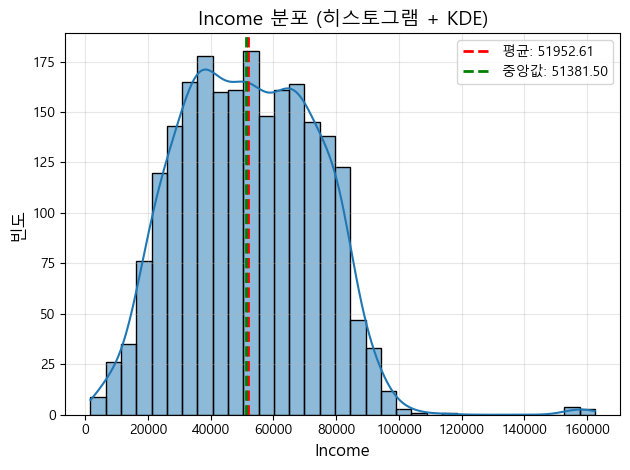


소득 변수이기에 극단적인 상위 값을 가진 그룹 존재


In [9]:
# TODO 1-2(a): Income 히스토그램 + KDE

Y = df['Income']

sns.histplot(
    data= Y, 
    bins= 'auto' ,          
    kde=True,        
    alpha=0.5,      
    edgecolor='black'
)
plt.axvline(Y.mean(), color='red', linestyle='--', linewidth=2, label=f'평균: {Y.mean():.2f}')
plt.axvline(Y.median(), color='green', linestyle='--', linewidth=2, label=f'중앙값: {Y.median():.2f}')
# 그래프 꾸미기
plt.title('Income 분포 (히스토그램 + KDE)', fontsize=14)
plt.xlabel('Income', fontsize=12)
plt.ylabel('빈도', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n소득 변수이기에 극단적인 상위 값을 가진 그룹 존재") 

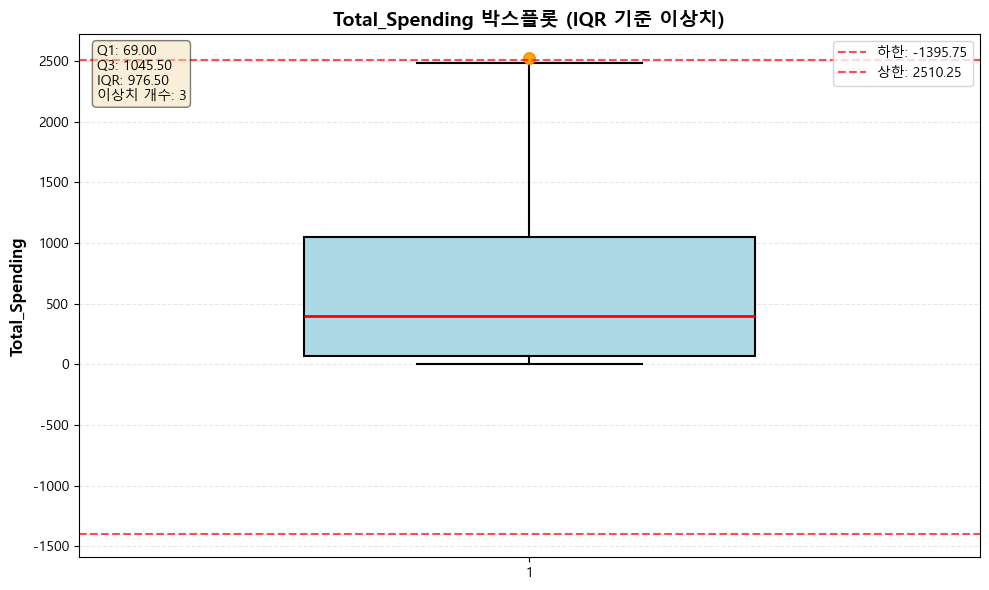


📊 Total_Spending 이상치 분석
하한선 (Q1 - 1.5×IQR): -1395.75
상한선 (Q3 + 1.5×IQR): 2510.25
이상치 개수: 3 / 2236 (0.13%)

이상치 값:
[2524, 2525, 2525]

이상치 행:
        ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
1179  5735        1991      Master         Single  90638.0        0         0   
1492  1763        1988  Graduation       Together  87679.0        0         0   
1572  5350        1991      Master         Single  90638.0        0         0   

     Dt_Customer  Recency  MntWines  ...  Total_Spending  Total_Purchases  \
1179  2014-02-13       29      1156  ...            2525               17   
1492  2013-07-27       62      1259  ...            2524               28   
1572  2014-02-13       29      1156  ...            2525               17   

      Total_Accepted  Has_Children  Income_Group  Age_Group  Education_Group  \
1179               1         False          High     30대 이하     Postgraduate   
1492               4         False          High     30대 이하     

In [10]:
# TODO 1-2(b): Total_Spending 박스플롯 + IQR 기준 이상치

column_name = 'Total_Spending' 
data = df[column_name]

# IQR 계산
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

# 이상치 경계
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치 추출
outliers = data[(data < lower_bound) | (data > upper_bound)]

# 시각화
fig, ax = plt.subplots(figsize=(10, 6))

# 박스플롯
bp = ax.boxplot(
    data.dropna(),
    vert=True,
    patch_artist=True,
    widths=0.5,
    boxprops=dict(facecolor='lightblue', edgecolor='black', linewidth=1.5),
    medianprops=dict(color='red', linewidth=2),
    whiskerprops=dict(color='black', linewidth=1.5),
    capprops=dict(color='black', linewidth=1.5),
    flierprops=dict(marker='o', markerfacecolor='orange', markersize=8, 
                    markeredgecolor='darkorange', alpha=0.7)
)

# 이상치 경계선 표시
ax.axhline(y=lower_bound, color='red', linestyle='--', linewidth=1.5, 
           label=f'하한: {lower_bound:.2f}', alpha=0.7)
ax.axhline(y=upper_bound, color='red', linestyle='--', linewidth=1.5, 
           label=f'상한: {upper_bound:.2f}', alpha=0.7)

# 그래프 꾸미기
ax.set_ylabel(column_name, fontsize=12, fontweight='bold')
ax.set_title(f'{column_name} 박스플롯 (IQR 기준 이상치)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend(loc='upper right')

# 통계 정보 텍스트
stats_text = f'Q1: {Q1:.2f}\nQ3: {Q3:.2f}\nIQR: {IQR:.2f}\n이상치 개수: {len(outliers)}'
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# 이상치 출력
print(f"\n📊 {column_name} 이상치 분석")
print(f"{'='*50}")
print(f"하한선 (Q1 - 1.5×IQR): {lower_bound:.2f}")
print(f"상한선 (Q3 + 1.5×IQR): {upper_bound:.2f}")
print(f"이상치 개수: {len(outliers)} / {len(data)} ({len(outliers)/len(data)*100:.2f}%)")
print(f"\n이상치 값:\n{outliers.sort_values().to_list()}")

# 이상치 경계 범위를 벗어나는 소비패턴 3개를 발견

print(f"\n이상치 행:\n{df.loc[df['Total_Spending'].isin (outliers)]}")

print(f"\n ID, 공통점 없음 ,날짜 공통점 2014-2-13 탐색 필요")


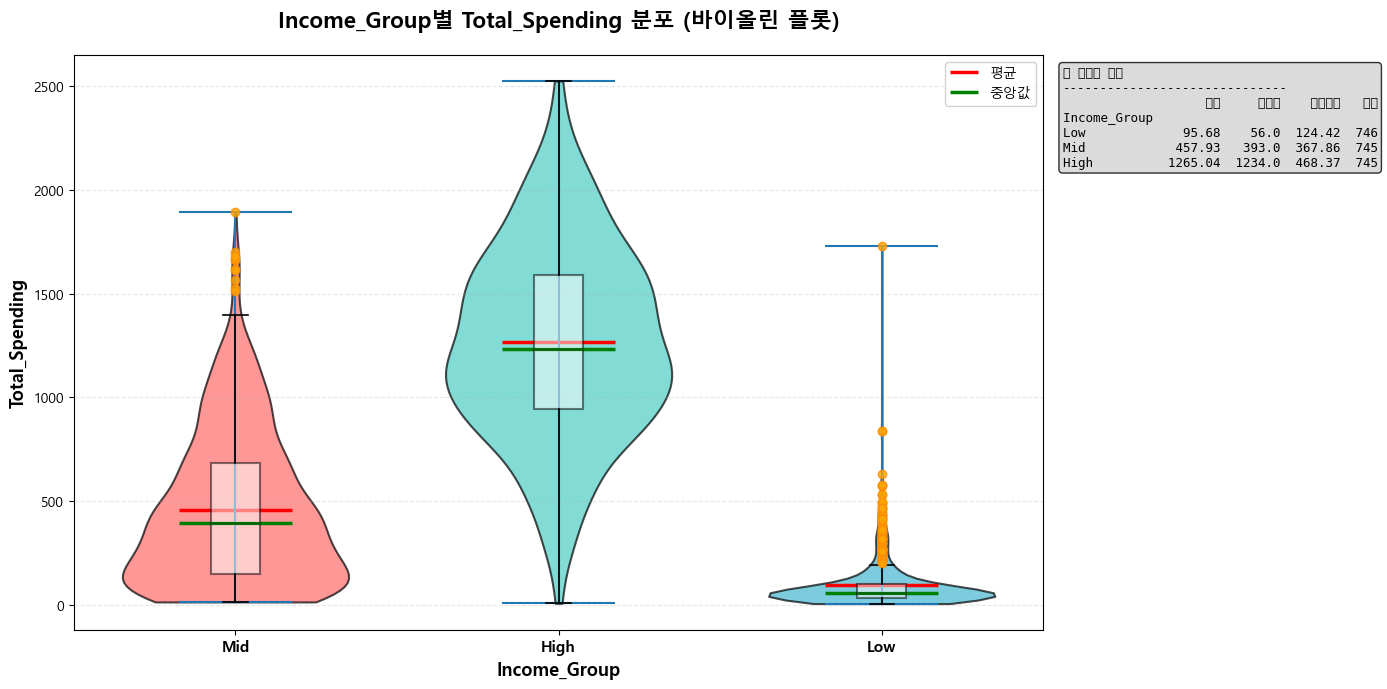


🎻 Income_Group별 Total_Spending 통계
                   평균     중앙값    표준편차   개수
Income_Group                              
Low             95.68    56.0  124.42  746
Mid            457.93   393.0  367.86  745
High          1265.04  1234.0  468.37  745

전체 평균: 605.99
전체 중앙값: 396.50
전체 표준편차: 601.87
그룹간 경계에 불안성이 보여짐 그룹 기준 변경고려 필요성


In [11]:
# TODO 1-2(c): Income_Group별 Total_Spending 바이올린 플롯


group_column = 'Income_Group'      # ← 그룹 변수 (카테고리)
value_column = 'Total_Spending'    # ← 값 변수 (연속형)


# 데이터 준비
plot_data = df[[group_column, value_column]].dropna()

# 그룹별 통계 계산
group_stats = plot_data.groupby(group_column)[value_column].agg([
    ('평균', 'mean'),
    ('중앙값', 'median'),
    ('표준편차', 'std'),
    ('개수', 'count')
]).round(2)

# 시각화
fig, ax = plt.subplots(figsize=(14, 7))

# 바이올린 플롯
violin_parts = ax.violinplot(
    dataset=[plot_data[plot_data[group_column] == group][value_column].dropna() 
             for group in plot_data[group_column].unique()],
    positions=range(len(plot_data[group_column].unique())),
    widths=0.7,
    showmeans=True,
    showmedians=True,
    showextrema=True
)

# 바이올린 색상 설정
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#DDA15E']
for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(colors[i % len(colors)])
    pc.set_alpha(0.7)
    pc.set_edgecolor('black')
    pc.set_linewidth(1.5)

# 평균선 스타일
violin_parts['cmeans'].set_edgecolor('red')
violin_parts['cmeans'].set_linewidth(2.5)
violin_parts['cmeans'].set_label('평균')

# 중앙값선 스타일
violin_parts['cmedians'].set_edgecolor('green')
violin_parts['cmedians'].set_linewidth(2.5)
violin_parts['cmedians'].set_label('중앙값')

# 박스플롯 오버레이 (선택)
bp = ax.boxplot(
    [plot_data[plot_data[group_column] == group][value_column].dropna() 
     for group in plot_data[group_column].unique()],
    positions=range(len(plot_data[group_column].unique())),
    widths=0.15,
    patch_artist=True,
    boxprops=dict(facecolor='white', edgecolor='black', alpha=0.5, linewidth=1.5),
    medianprops=dict(color='darkgreen', linewidth=2),
    whiskerprops=dict(color='black', linewidth=1.2),
    capprops=dict(color='black', linewidth=1.2),
    flierprops=dict(marker='o', markerfacecolor='orange', markersize=6, 
                    markeredgecolor='darkorange', alpha=0.8)
)

# x축 레이블 설정
ax.set_xticks(range(len(plot_data[group_column].unique())))
ax.set_xticklabels(plot_data[group_column].unique(), fontsize=11, fontweight='bold')

# 그래프 꾸미기
ax.set_xlabel(group_column, fontsize=13, fontweight='bold')
ax.set_ylabel(value_column, fontsize=13, fontweight='bold')
ax.set_title(f'{group_column}별 {value_column} 분포 (바이올린 플롯)', 
             fontsize=16, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend(loc='upper right', fontsize=10, framealpha=0.9)

# 통계 테이블 추가
table_text = group_stats.to_string()
ax.text(
    1.02, 0.98, f'📊 그룹별 통계\n{"-"*30}\n{table_text}',
    transform=ax.transAxes,
    fontsize=9,
    verticalalignment='top',
    fontfamily='monospace',
    bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8, edgecolor='black')
)

plt.tight_layout()
plt.show()

# 콘솔 출력
print(f"\n🎻 {group_column}별 {value_column} 통계")
print(f"{'='*70}")
print(group_stats)
print(f"\n전체 평균: {plot_data[value_column].mean():.2f}")
print(f"전체 중앙값: {plot_data[value_column].median():.2f}")
print(f"전체 표준편차: {plot_data[value_column].std():.2f}")

print(f"그룹간 경계에 불안성이 보여짐 그룹 기준 변경고려 필요성")

### 문제 1-3. 왜도와 첨도

6개 소비 카테고리(MntWines ~ MntGoldProds)의 왜도(Skewness)와 첨도(Kurtosis)를 계산하고,
2×3 히스토그램 그리드를 그려 분포 형태를 비교하세요.

**왜도 해석**
- 왜도 > 0: 오른쪽 꼬리가 긴 분포 
- 왜도 < 0: 왼쪽 꼬리가 긴 분포 
- 왜도 ≈ 0: 좌우 대칭에 가까운 분포

**첨도 해석** 
- 초과 첨도 > 0: 정규분포보다 중앙이 뾰족하고 꼬리가 두꺼운 분포 
- 초과 첨도 < 0: 정규분포보다 중앙이 평평하고 꼬리가 얇은 분포
- 초과 첨도 ≈ 0: 정규분포와 유사한 형태

In [12]:
spending_names = ['Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold']
hist_colors = [COLORS['blue'], COLORS['violet'], COLORS['teal'],
               COLORS['emerald'], COLORS['amber'], COLORS['rose']]

# TODO 1-3(a): 6개 카테고리의 왜도/첨도 계산 및 출력
df_3 = df[["MntWines","MntFruits","MntMeatProducts","MntFishProducts", "MntSweetProducts","MntGoldProds"]]
df_3.columns = spending_names
df_3.info()

df_skew_kurt = pd.DataFrame({
    "왜도": [df_3["Wines"].skew(), df_3["Fruits"].skew(),
           df_3["Meat"].skew(),df_3["Fish"].skew(),
           df_3["Sweets"].skew(),df_3["Gold"].skew() ], 
    "첨도": [df_3["Wines"].kurt(), df_3["Fruits"].kurt(),
           df_3["Meat"].kurt(),df_3["Fish"].kurt(),
           df_3["Sweets"].kurt(),df_3["Gold"].kurt() ], 
},index=(spending_names)
)
df_skew_kurt

<class 'pandas.DataFrame'>
Index: 2236 entries, 0 to 2239
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Wines   2236 non-null   int64
 1   Fruits  2236 non-null   int64
 2   Meat    2236 non-null   int64
 3   Fish    2236 non-null   int64
 4   Sweets  2236 non-null   int64
 5   Gold    2236 non-null   int64
dtypes: int64(6)
memory usage: 122.3 KB


,왜도,첨도
Wines,1.176036,0.600531
Fruits,2.104241,4.069754
Meat,2.085282,5.530136
Fish,1.919970,3.096020
Sweets,2.135674,4.372062
Gold,1.885136,3.558349


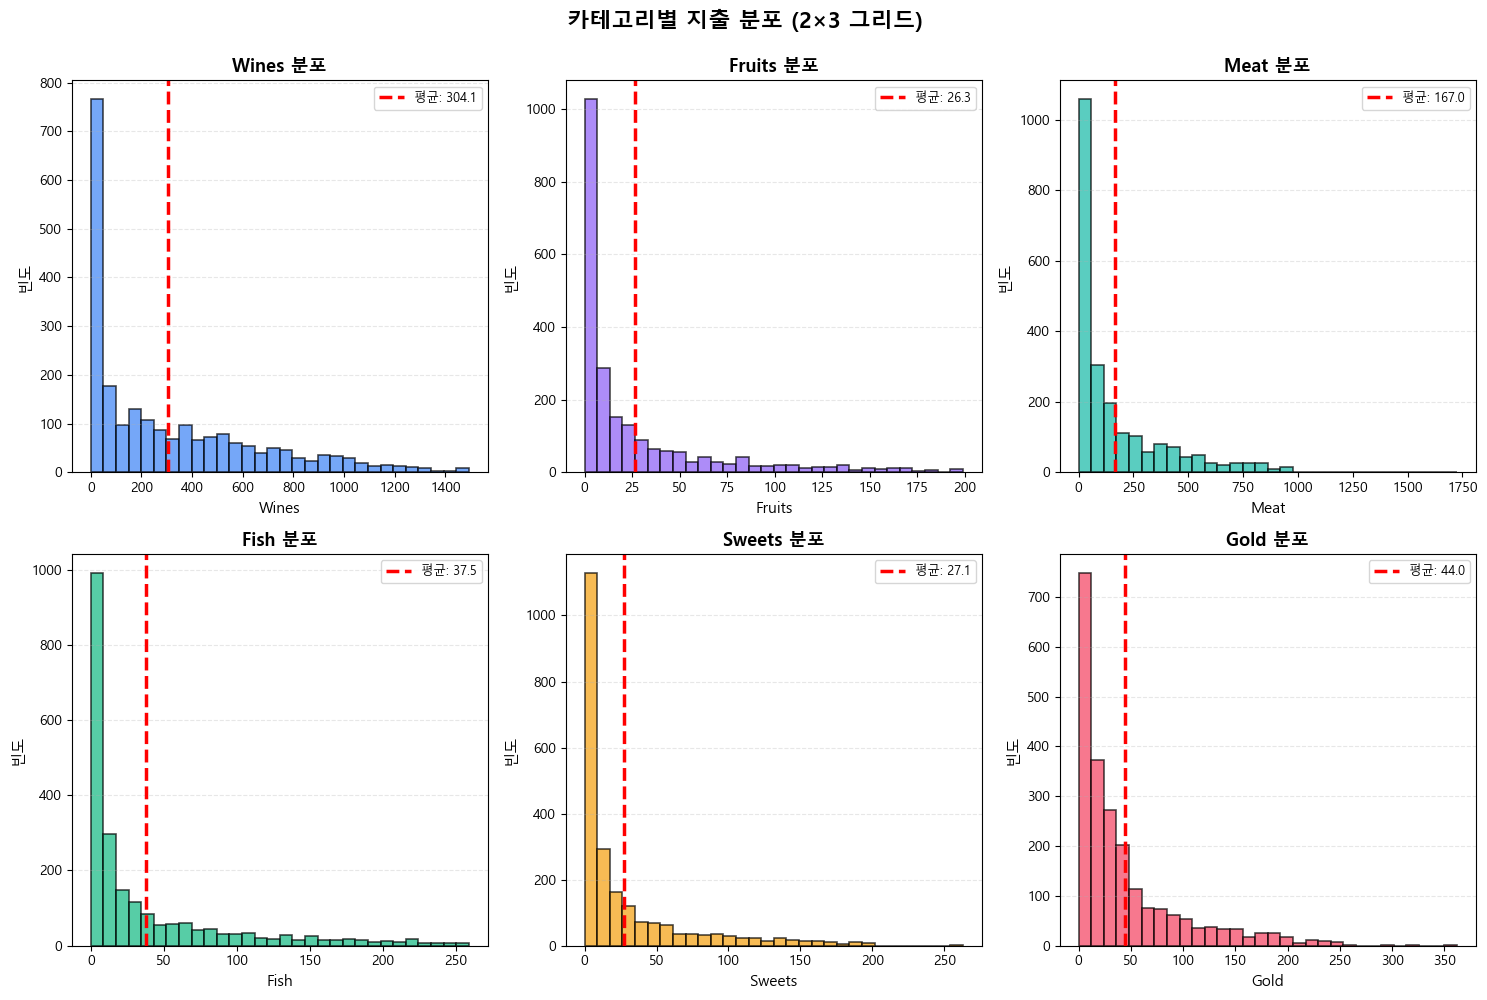

In [13]:
# TODO 1-3(b): 2×3 히스토그램 그리드 (각 카테고리 분포 + 평균선)


fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# 각 서브플롯에 히스토그램 그리기
for i, (col, color) in enumerate(zip(spending_names, hist_colors)):
    ax = axes[i]
    data = df_3[col].dropna()
    
    # 평균 계산
    mean_val = data.mean()
    
    # 히스토그램
    ax.hist(
        data,
        bins=30,
        color=color,
        alpha=0.7,
        edgecolor='black',
        linewidth=1.2
    )
    
    # 평균선
    ax.axvline(
        x=mean_val,
        color='red',
        linestyle='--',
        linewidth=2.5,
        label=f'평균: {mean_val:.1f}'
    )
    
    # 제목 및 레이블
    ax.set_title(f'{col} 분포', fontsize=13, fontweight='bold')
    ax.set_xlabel(col, fontsize=11)
    ax.set_ylabel('빈도', fontsize=11)
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(axis='y', alpha=0.3, linestyle='--')

# 전체 제목
fig.suptitle('카테고리별 지출 분포 (2×3 그리드)', 
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()


### 문제 1-4. 비즈니스 인사이트 정리

Part 1의 분석 결과를 바탕으로 다음을 정리하세요.

1. 고객 특성 요약 (연령, 소득, 소비 특성)
2. 핵심 발견 사항 (분포 특성, 그룹 간 차이)
3. 후속 분석에서 검증할 가설 (최소 3개)

In [14]:
# TODO 1-4: 비즈니스 인사이트 정리
print(f"\n1. 고객특성 ")
print("소득 변수는 극단적인 상위 값을 가진 그룹 존재함, 절사평균또는 중위값이 분포의 대표성을 나타내기에 더 알맞음 ")
print("총 소비 변수는 큰 양의 왜도 형태를 보이며, 가장큰 변동계수를 보임 ")
print("AGE 변수는 최빈값이 중요한데, 데이터는 40대~ 50대가 주된 특성을 보임")

print(f"\n 2. 핵심 발견 사항 ")
print(f" 소득 분포 그룹 분리 필요, 기준: 130,000")
print(f" 총 소비 분포에서 이상치 경계 범위를 벗어나는 소비패턴 3개를 발견")
print(f" ID 공통점은 없지만 날짜 공통점 존재 2014-2-13 탐색 필요")
print(f" 소득 그룹간 경계에 불안성이 보여짐 그룹 기준 변경 고려가 필요함")
print(f" 소비 카테고리간 분포가 양의 왜도 형태로 비슷한 양상을 보임")

print(f"\n 3. 가설 ")
print(f"1. H0: 소비 카테고리 간 분포는 동일한가?  ")
print(f"2. H0: 소득 분포에서 극단 그룹을 제거한 분포는 정규분포를 따르는가?  ")
print(f"3. H0: 소비 분포의 그룹별 분포는 동일한가?  ")


1. 고객특성 
소득 변수는 극단적인 상위 값을 가진 그룹 존재함, 절사평균또는 중위값이 분포의 대표성을 나타내기에 더 알맞음 
총 소비 변수는 큰 양의 왜도 형태를 보이며, 가장큰 변동계수를 보임 
AGE 변수는 최빈값이 중요한데, 데이터는 40대~ 50대가 주된 특성을 보임

 2. 핵심 발견 사항 
 소득 분포 그룹 분리 필요, 기준: 130,000
 총 소비 분포에서 이상치 경계 범위를 벗어나는 소비패턴 3개를 발견
 ID 공통점은 없지만 날짜 공통점 존재 2014-2-13 탐색 필요
 소득 그룹간 경계에 불안성이 보여짐 그룹 기준 변경 고려가 필요함
 소비 카테고리간 분포가 양의 왜도 형태로 비슷한 양상을 보임

 3. 가설 
1. H0: 소비 카테고리 간 분포는 동일한가?  
2. H0: 소득 분포에서 극단 그룹을 제거한 분포는 정규분포를 따르는가?  
3. H0: 소비 분포의 그룹별 분포는 동일한가?  


---
## Part 2: 확률분포 모델링 — "고객 행동은 어떤 패턴을 따르는가?"

실제 고객 데이터에 이론적 확률분포를 적합하여 고객 행동을 모델링합니다.

### 문제 2-1. 이항분포 — 캠페인 수락 모델링

`Response` 열에서 수락률 p를 계산하고, 이를 이항분포 B(n, p)에 적용합니다.

- **(a)** 10명 중 정확히 2명이 수락할 확률
  - B(n=10, p) 에서 P(X = 2) 계산

- **(b)** 10명 중 3명 이상이 수락할 확률
  - B(n=10, p) 에서 P(X ≥ 3) 계산

- **(c)** 이항분포 PMF 시각화
  - B(n=10, p) 의 모든 경우(X = 0, 1, ..., 10)에 대한
    이론 확률을 막대그래프로 그립니다.

- **(d)** n=100 으로 확장 — 세 가지 질문
  - **기대 수락자 수**: E(X) 계산
  - **15명 이상 수락 확률**: P(X ≥ 15) 계산
  - **90% 보장 최소 수락 수**: P(X ≤ k) ≥ 0.90 을 만족하는 최솟값 k 탐색

In [15]:
# TODO 2-1(a),(b): 수락률(p) 계산 + P(X=2), P(X≥3) 계산 및 출력
n_trial = 10
p = df["Response"].mean()
print(f"수락률: {p:.2f}")
# 분포 생성
Bi_accept_dist = stats.binom(n_trial, p)  

x2 = Bi_accept_dist.pmf(2)
print(f"\n 10명 중 정확히 2명이 수락할 확률: {x2:.3f}")


x3_over = Bi_accept_dist.sf(2)
print(f"\n 10명 중 3명 이상이 수락할 확률: {x3_over:.3f}")


수락률: 0.15

 10명 중 정확히 2명이 수락할 확률: 0.275

 10명 중 3명 이상이 수락할 확률: 0.178


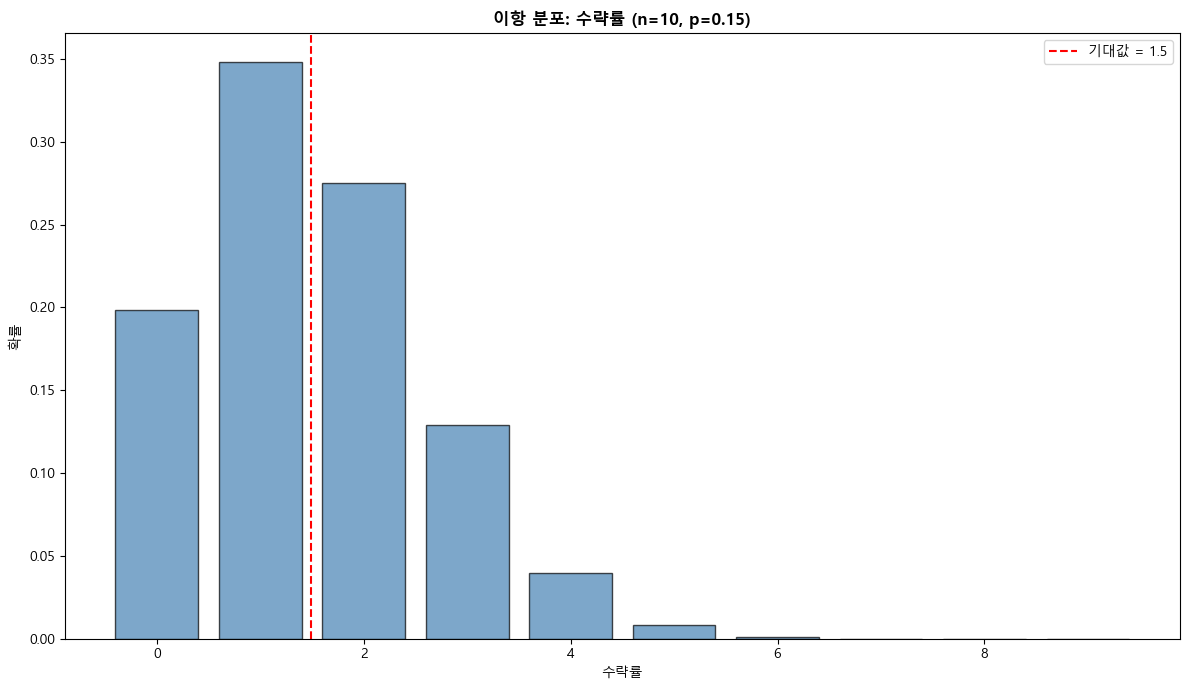

In [16]:
# TODO 2-1(c): 이항분포 PMF 시각화
# 시각화: 불량품 개수 분포
fig, ax = plt.subplots(figsize=(12, 7))

# PMF 그래프
k = np.arange(0, 10)
pmf = Bi_accept_dist.pmf(k)

ax.bar(k, pmf, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(n_trial * p, color='red', linestyle='--',
                label=f'기대값 = {n_trial * p:.1f}')
ax.set_xlabel('수략률')
ax.set_ylabel('확률')
ax.set_title('이항 분포: 수략률 (n=10, p=0.15)', fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()


In [17]:
# TODO 2-1(d): 100명 발송 시 기대 수락자, P(X≥15), 90% 보장 최소 수락 수
n_campaign = 100
dist_100 = stats.binom(n_campaign, p)

print(f"100명 발송 시 기대 수락자: {n_campaign*p:.2f}")

p_15_over = dist_100.sf(14)
print(f"\n P(X≥15): {p_15_over:.2f}")

ppf_90 = dist_100.ppf(0.9)
print(f"\n 90% 보장 최소 수락 수: {ppf_90:.2f}")


100명 발송 시 기대 수락자: 14.94

 P(X≥15): 0.54

 90% 보장 최소 수락 수: 20.00


### 문제 2-2. 포아송 분포 — 웹사이트 방문 모델링

`NumWebVisitsMonth`(월간 웹 방문 수)에 포아송 분포를 적합합니다.

- **(a)** λ 추정 및 적합 평가
  - 표본 평균으로 λ를 추정하고,
    표본 평균 ≈ 표본 분산인지 확인하여 포아송 분포 적합 여부를 평가합니다.

- **(b)** 실측 vs 이론 PMF 시각화
  - 각 방문 횟수(0회, 1회, 2회, ...)별 실제 비율(실측 PMF)과
    포아송 분포의 이론 확률(이론 PMF)을 막대그래프로 겹쳐 그려 비교합니다.

- **(c)** 포아송 분포 활용 — 두 가지 실무 시나리오
  - **과다 방문 고객 비율**: P(X ≥ 10) 계산
    → 추정된 포아송 분포에서 월 10회 이상 방문할 확률이 몇 %인지 구합니다.
  - **서버 용량 계획**: 상위 5% 기준값 k 계산, 즉 P(X ≤ k) = 0.95 를 만족하는 k 탐색
    → 전체 고객의 95%를 커버할 수 있는 최대 방문 횟수를 구하고,
       이를 서버가 처리해야 할 기준 용량으로 활용합니다.

In [18]:
web_visits = df['NumWebVisitsMonth']

# TODO 2-2(a): 람다 추정 및 포아송 적합 평가 (월간 웹 방문수 평균≈분산 값이 비슷한지 확인)
a=web_visits.mean()
b=web_visits.var(ddof=1 )
c=web_visits.var(ddof=0 )
popo = pd.DataFrame({
    "평균" :[a] ,
    "표본분산":[b],
    "모분산":[c ]}
)
display(popo)
print("포아송 근사 가능")


,평균,표본분산,모분산
0,5.318873,5.889773,5.887139


포아송 근사 가능


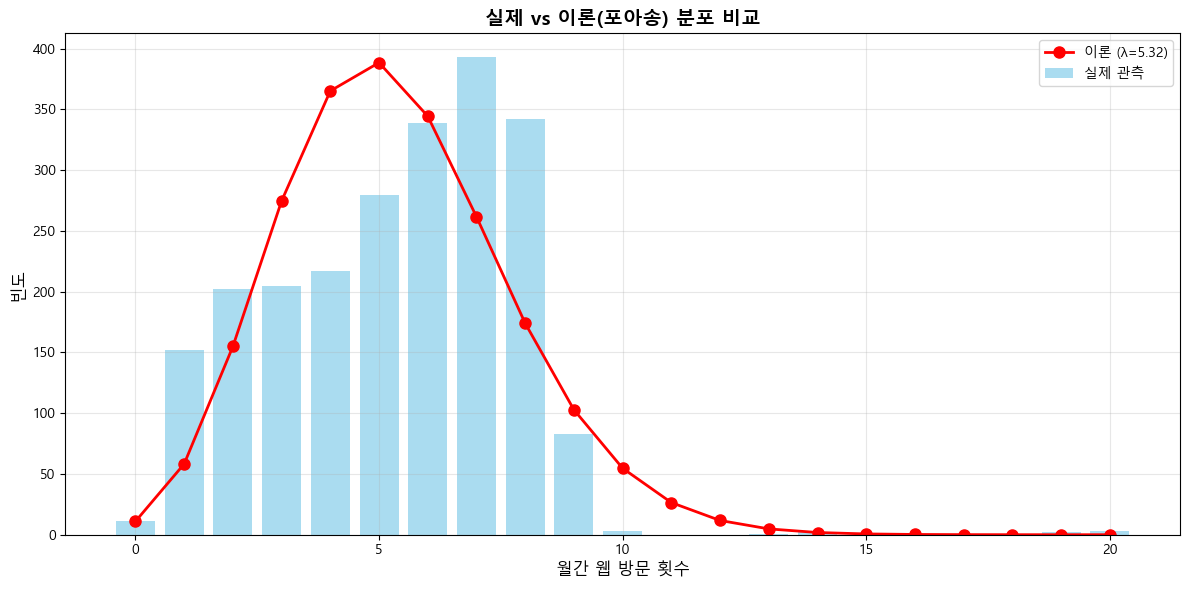

In [19]:
# TODO 2-2(b): 월간 웹 방문수 막대그래프 vs 이론 PMF 비교 시각화 (두 그래프를 겹쳐서 그리기)
lam_web = web_visits.mean()
poisson_dist = stats.poisson(lam_web)

n= len(web_visits)
real_web = web_visits.value_counts().sort_values()



# X 범위와 이론값
x_range = np.arange(0, web_visits.max() + 1)
theoretical_counts = poisson_dist.pmf(x_range) * n

# 그래프
plt.figure(figsize=(12, 6))

# 실제 데이터 
plt.bar(real_web.index, real_web.values, 
        color='skyblue', alpha=0.7, label='실제 관측')

# 이론 분포 
plt.plot(x_range, theoretical_counts, 
         'ro-', linewidth=2, markersize=8, label=f'이론 (λ={lam_web:.2f})')

plt.xlabel('월간 웹 방문 횟수', fontsize=12)
plt.ylabel('빈도', fontsize=12)
plt.title('실제 vs 이론(포아송) 분포 비교', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 20 회라는 극단값이 존재해 분포 모양이 흔들림 

In [20]:
a= web_visits[web_visits>= 15]
a
# 5개

9       20
774     20
1042    19
1245    20
1328    17
1846    19
Name: NumWebVisitsMonth, dtype: int64

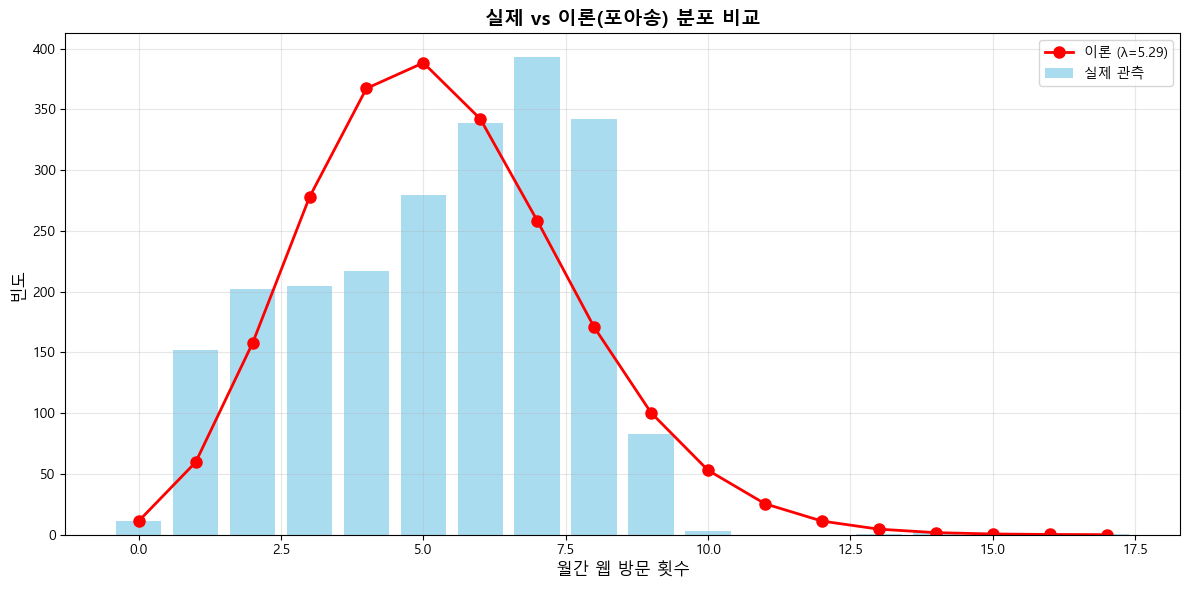

In [21]:
# 이상치 제거 버전 
web_visits2 = web_visits[web_visits < 18]

lam_web = web_visits2.mean()
poisson_dist2 = stats.poisson(lam_web)

n= len(web_visits2)
real_web = web_visits2.value_counts().sort_values()



# X 범위와 이론값
x_range = np.arange(0, web_visits2.max() + 1)
theoretical_counts = poisson_dist2.pmf(x_range) * n

# 그래프
plt.figure(figsize=(12, 6))

# 실제 데이터 
plt.bar(real_web.index, real_web.values, 
        color='skyblue', alpha=0.7, label='실제 관측')

# 이론 분포 
plt.plot(x_range, theoretical_counts, 
         'ro-', linewidth=2, markersize=8, label=f'이론 (λ={lam_web:.2f})')

plt.xlabel('월간 웹 방문 횟수', fontsize=12)
plt.ylabel('빈도', fontsize=12)
plt.title('실제 vs 이론(포아송) 분포 비교', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 큰 변화는 없음

In [22]:
# TODO 2-2(c):
# - 과다 방문 고객: 포아송 분포로 P(X ≥ 10) 계산 (월 10회 이상 방문 확률)
px10_po = poisson_dist.sf(9)
print(f"월 10회 이상 방문 확률 {px10_po:.2f}")

# - 서버 용량 계획: P(X ≤ k) ≥ 0.95 를 만족하는 최솟값 k 탐색 (상위 5% 기준)
k_95per = poisson_dist.ppf(0.95)
print(f"누적 95% 를 만족하는 최소 값  {k_95per:.2f} 명, 따라서 9명을 기준으로 설계하면 문제가 안될 확률이 95%")



월 10회 이상 방문 확률 0.04
누적 95% 를 만족하는 최소 값  9.00 명, 따라서 9명을 기준으로 설계하면 문제가 안될 확률이 95%


### 문제 2-3. 정규분포 — 소득 모델링

`Income`에 정규분포를 적합합니다.
Part 1에서 Income의 왜도가 작고 평균≈중앙값임을 확인했습니다. 정규분포가 잘 맞을까요?

- **(a)** μ, σ 추정 후 CDF로 P(Income < 30000), P(Income > 80000) 계산,
 PPF로 상위 10% 소득 기준값 계산 — **이론 확률과 실측 비율을 비교**하세요
- **(b)** 히스토그램 + 정규 분포 PDF와 겹쳐 그리기
- **(c)** 정규분포 활용 — 두 가지 질문
  - **VIP 기준선**: 상위 5% 소득 기준값
    → "이 금액 이상이면 VIP 고객으로 분류"
  - **할인 대상 기준선**: 하위 10% 소득 기준값
    → "이 금액 이하이면 할인 대상 고객으로 분류"


In [23]:
# TODO 2-3(a): μ, σ 추정 → CDF로 P(Income<30000), P(Income>80000) 계산
#               PPF로 상위 10% 소득 기준값 계산 → 이론 확률과 실측 비율 비교

mu = df["Income"].mean()
s= df["Income"].std(ddof= 1)
dist_norm_in =  stats.norm(mu,s)
p_under = dist_norm_in.cdf(30000)
p_over = dist_norm_in.sf(80000)
top_10 = dist_norm_in.ppf(0.9)

incom = df["Income"]
data_p_under0 =  (incom[incom <= 30000 ].count()) /len(incom)
data_p_over =  (incom[incom >= 80000 ].count()) /len(incom)
data_top_10 =  (incom[incom >= top_10 ].count()) /len(incom)


print(f"P(Income<30000) {p_under:.2f} ")
print(f"30000보다 낮은 실제 데이터 비율 {data_p_under0:.2f} ")
print(f"\nP(Income>80000) {p_over:.2f} ")
print(f"80000보다 높은 실제 데이터 비율 {data_p_over:.2f} ")
print(f"\n상위 10% {top_10:.2f}")
print(f"79392 를 넘은 실제 실측 비율 {data_top_10} ")


P(Income<30000) 0.15 
30000보다 낮은 실제 데이터 비율 0.17 

P(Income>80000) 0.10 
80000보다 높은 실제 데이터 비율 0.10 

상위 10% 79392.51
79392 를 넘은 실제 실측 비율 0.1050983899821109 


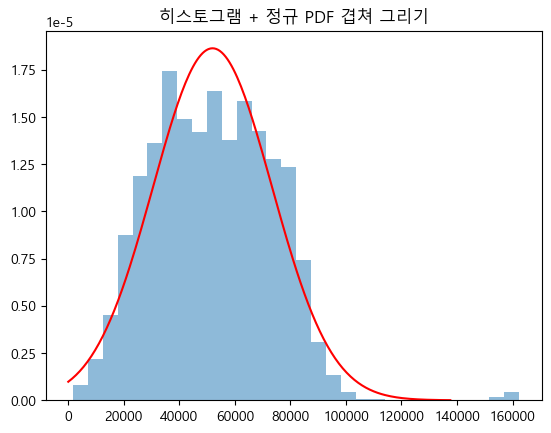

In [24]:
# TODO 2-3(b): 히스토그램 + 정규 PDF 겹쳐 그리기

x= np.linspace(0, mu+4*s, 200)
y= dist_norm_in.pdf(x)

plt.hist(incom, bins=30, density= True, alpha=0.5 )
plt.plot(x,y, "r-")
plt.title("히스토그램 + 정규 PDF 겹쳐 그리기")
plt.show()

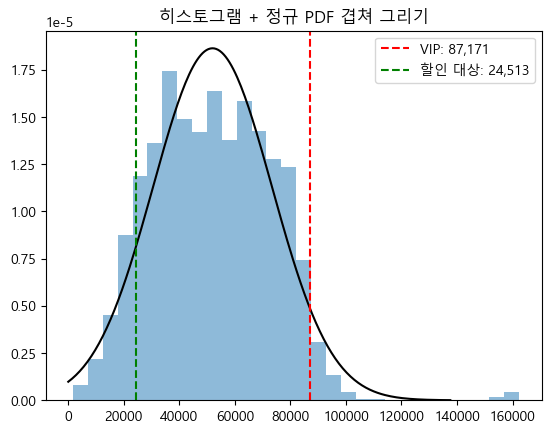

In [25]:
# TODO 2-3(c): 실무 시나리오 — VIP(상위 5%) 기준선 + 할인 대상(하위 10%) 기준선


x= np.linspace(0, mu+4*s, 200)
y= dist_norm_in.pdf(x)
top_5 = dist_norm_in.ppf(0.95)
under_10 = dist_norm_in.ppf(0.1)

plt.hist(incom, bins=30, density= True, alpha=0.5 )
plt.plot(x,y, "black")
plt.title("히스토그램 + 정규 PDF 겹쳐 그리기")
plt.axvline(top_5, color = "red",linestyle='--', label=f'VIP: {top_5:,.0f}')
plt.axvline(under_10, color = "green",linestyle='--', label=f'할인 대상: {under_10:,.0f}')
plt.legend()
plt.show()

---
## Part 3: 추정과 가설검정 — "고소득 고객과 저소득 고객의 소비는 다른가?"

신뢰구간과 가설검정을 통해 고객 그룹 간 차이를 통계적으로 검증합니다.

### 문제 3-1. 신뢰구간 추정

- **(a)** Total_Spending 평균의 90%, 95%, 99% 신뢰구간을 계산하세요.
- **(b)** Income_Group별 95% CI를 계산하고 오차막대 그래프로 비교하세요.

CI = [x̄ - t × SE, x̄ + t × SE] (SE = s / √n)

In [26]:
# TODO 3-1(a): Total_Spending 평균의 신뢰구간 (90%, 95%, 99%)
# CI = x̄ ± t(α/2, n-1) × SE
mu_t= df["Total_Spending"].mean()
se = df["Total_Spending"].std() / np.sqrt(len(df["Total_Spending"]))
n= len(df["Total_Spending"])

for confidence in (0.9,0.95,0.99):
    ci_lower, ci_upper =stats.t.interval(confidence, df = n-1, loc=mu_t, scale=  se )
    print(ci_lower, ci_upper)

585.0420537644019 626.9311126041133
581.0264644747788 630.9467018937364
573.1731693894566 638.7999969790586


신뢰 수준 95% Low: 86.73 104.62
신뢰 수준 95% Mid: 431.47 484.39
신뢰 수준 95% High: 1231.35 1298.72


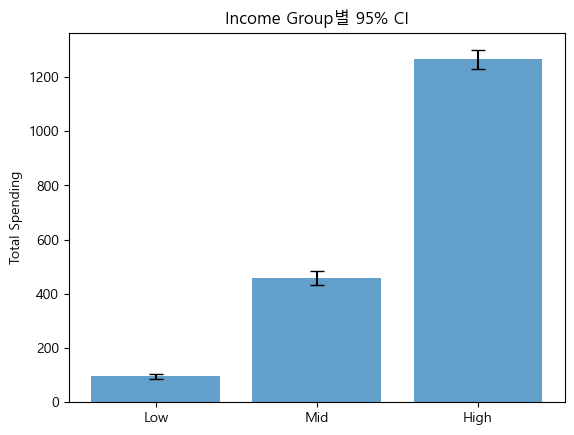

In [27]:
# TODO 3-1(b): Income_Group별 95% CI 계산 + 오차막대 그래프
in_grup_mu= df.groupby("Income_Group")["Total_Spending"]


names =[]
means =[]
ci_lowers =[]
ci_uppers =[]
for name, group in in_grup_mu: 
    n_group = len(group)
    mu_group = group.mean()
    se_g =  group.std()/ np.sqrt(n_group)
    ci_lower, ci_upper =stats.t.interval(0.95, df = n_group-1, loc=mu_group, scale=  se_g )
    print(f"신뢰 수준 95% {name}: {ci_lower:.2f} {ci_upper:.2f}")
    names.append(name)
    means.append(mu_group)
    ci_lowers.append(mu_group- ci_lower)
    ci_uppers.append( ci_upper -mu_group)

plt.bar(names, means, yerr=[ci_lowers, ci_uppers], capsize=5, alpha=0.7)
plt.ylabel("Total Spending")
plt.title("Income Group별 95% CI")
plt.show()


### 문제 3-2. 독립표본 t-검정 (Welch's t-test)

**가설**: 자녀가 없는 고객의 총 소비가 자녀가 있는 고객과 다른가?

- H₀: μ_무자녀 = μ_유자녀
- H₁: μ_무자녀 ≠ μ_유자녀

Cohen's d 해석 기준: |d| < 0.5 작은, 0.5~0.8 중간, > 0.8 큰 효과

In [28]:
no_child = df[~df['Has_Children']]['Total_Spending']
yes_child = df[df['Has_Children']]['Total_Spending']

# TODO 3-2: Welch's t-검정 수행 + Cohen's d 계산 + 결과 출력
# Welch's t-검정 수행
t_stat, p_value = stats.ttest_ind( no_child, yes_child, equal_var=False, alternative= "two-sided")

# Cohen's d 계산
s_avg = np.sqrt((np.var(no_child, ddof=1) + np.var(yes_child, ddof=1)) / 2)
d_chi = abs(np.mean(no_child) - np.mean(yes_child)) / s_avg

# 결과 
print(f"welch's t 검정 결과 p_value: {p_value}")
print(f"귀무가설 기각 두 분포는 동일하지 않음")
print(f"\n Cohen's d: {d_chi:.2f}로 매우 큰 효과 두 평균의 차이가 표준편차의 크기보다 크다.")

welch's t 검정 결과 p_value: 6.321230429385628e-105
귀무가설 기각 두 분포는 동일하지 않음

 Cohen's d: 1.25로 매우 큰 효과 두 평균의 차이가 표준편차의 크기보다 크다.


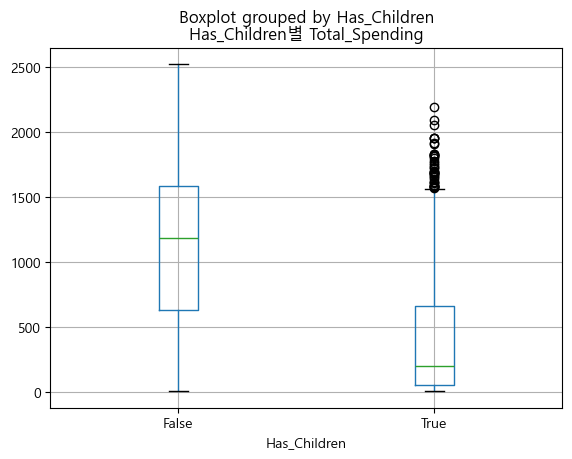

In [29]:
# TODO 3-2(c): 박스플롯 비교 시각화

df.boxplot(column="Total_Spending", by="Has_Children" )
plt.title('Has_Children별 Total_Spending')
plt.show()

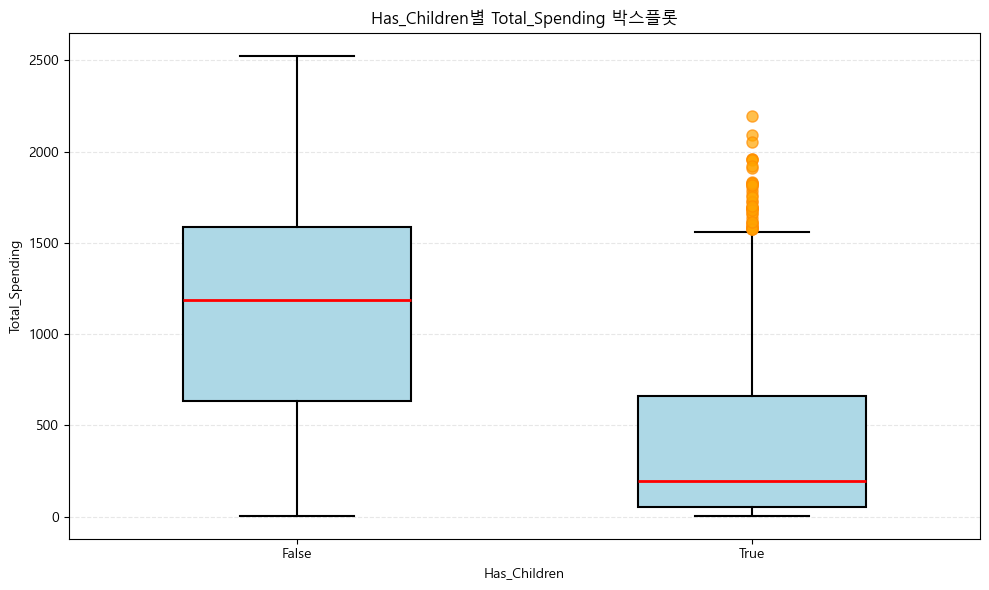

In [30]:
group_col = 'Has_Children'  # ← 그룹 기준 컬럼
column_name = 'Total_Spending'

groups = df.groupby(group_col)[column_name]
group_names = list(groups.groups.keys())
group_data = [group.dropna() for name, group in groups]

fig, ax = plt.subplots(figsize=(10, 6))

bp = ax.boxplot(
    group_data,          # 리스트로 넣으면 그룹별로 그려줌
    labels=group_names,  # x축 라벨
    vert=True,
    patch_artist=True,
    widths=0.5,
    boxprops=dict(facecolor='lightblue', edgecolor='black', linewidth=1.5),
    medianprops=dict(color='red', linewidth=2),
    whiskerprops=dict(color='black', linewidth=1.5),
    capprops=dict(color='black', linewidth=1.5),
    flierprops=dict(marker='o', markerfacecolor='orange', markersize=8,
                    markeredgecolor='darkorange', alpha=0.7)
)

ax.set_xlabel(group_col)
ax.set_ylabel(column_name)
ax.set_title(f'{group_col}별 {column_name} 박스플롯')
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

### 문제 3-3. 대응표본 t-검정

같은 고객의 **와인 소비**(`MntWines`)와 **육류 소비**(`MntMeatProducts`)를 비교합니다.

- H₀: μ_Wine = μ_Meat (차이 = 0)
- H₁: μ_Wine ≠ μ_Meat

In [31]:
wines = df['MntWines']
meat = df['MntMeatProducts']

# TODO 3-3: 차이 계산 + 대응표본 t-검정 + Cohen's d + 결과 출력


t_stat, p_value = stats.ttest_rel(wines, meat, alternative="two-sided")
diff = wines - meat
d = abs(np.mean(diff))/ np.std(diff, ddof= 1)
# 결과 
print(f"대응표본 t 검정 결과 p_value: {p_value}")
print(f"귀무가설 기각, 전후 차이는 동일하지 않음")
print(f"\n Cohen's d: {d:.2f}로 중간정도의 효과크기를 가지고 있다.")

대응표본 t 검정 결과 p_value: 5.391926544698085e-106
귀무가설 기각, 전후 차이는 동일하지 않음

 Cohen's d: 0.49로 중간정도의 효과크기를 가지고 있다.


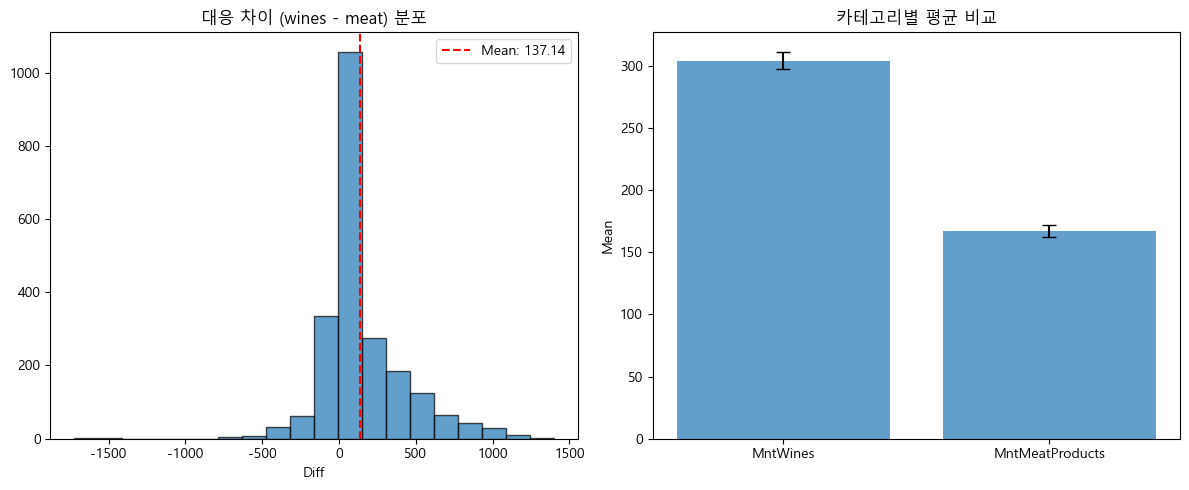

In [32]:
# TODO 3-3(b): (1) 대응 차이 히스토그램 (2) 카테고리별 평균 비교 막대그래프

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# (1) 대응 차이 히스토그램
ax1.hist(diff, bins=20, alpha=0.7, edgecolor='black')
ax1.axvline(diff.mean(), color='red', linestyle='--', label=f'Mean: {diff.mean():.2f}')
ax1.set_title('대응 차이 (wines - meat) 분포')
ax1.set_xlabel('Diff')
ax1.legend()

# (2) 카테고리별 평균 비교
before, after =  df['MntWines'], df['MntMeatProducts']

categories = ['MntWines', 'MntMeatProducts']
means = [before.mean(), after.mean()]
ax2.bar(categories, means, alpha=0.7, capsize=5,
        yerr=[before.sem(), after.sem()])
ax2.set_title('카테고리별 평균 비교')
ax2.set_ylabel('Mean')

plt.tight_layout()
plt.show()



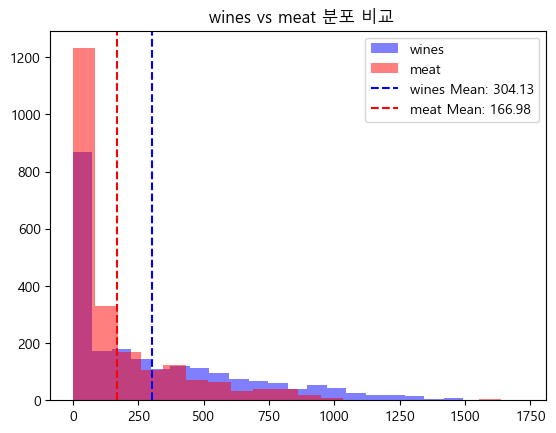

In [33]:
A = wines 
B= meat
plt.hist(A, bins=20, alpha=0.5, label='wines', color='blue')
plt.hist(B, bins=20, alpha=0.5, label='meat', color='red')
plt.axvline(A.mean(), color='blue', linestyle='--', label=f'wines Mean: {A.mean():.2f}')
plt.axvline(B.mean(), color='red', linestyle='--', label=f'meat Mean: {B.mean():.2f}')
plt.title(' wines vs meat 분포 비교')
plt.legend()
plt.show()

### 문제 3-4. 검정력 분석

- **(a)** 문제 3-2의 효과 크기와 표본 크기를 사용하여 검정력(Power)을 계산하세요.
- **(b)** 작은 효과(d=0.2)를 탐지하기 위해 필요한 그룹당 표본 크기를 구하세요.

In [34]:
power_analysis = TTestIndPower()

n1= len(yes_child)
n2= len(no_child)
# TODO 3-4(a): 문제 3-2 기준 검정력 계산
power_has = power_analysis.solve_power( 
    effect_size= d_chi, 
    alpha= 0.05, 
    nobs1= n1 ,
    ratio= n2 / n1 ,
    alternative= "two-sided"
)
print(f"{power_has}, 두 표본의 평균차이가(효과크기) 매우 크기에 검정력이 1이 나옴")


# TODO 3-4(b): 작은 효과(d=0.2) 탐지에 필요한 표본 크기 산정
need_n = power_analysis.solve_power( 
    effect_size= 0.2, 
    alpha= 0.05, 
    alternative= "two-sided",
    ratio= 1 ,
    power= power_has
)
print(f"\n검정력이 {power_has}이고 d= 0.2 일때, 필요한 표본 크기 {need_n} ")



1.0, 두 표본의 평균차이가(효과크기) 매우 크기에 검정력이 1이 나옴

검정력이 1.0이고 d= 0.2 일때, 필요한 표본 크기 50000.0 


---
## Part 4: 고급 검정 — "교육, 결혼, 캠페인 반응의 관계는?"

정규성 검정을 바탕으로 적절한 검정 방법을 선택하고,
범주형 변수 간 관계를 분석합니다.

### 문제 4-1. 정규성 + 등분산 검정

Education_Group별 Total_Spending의 정규성을 Shapiro-Wilk 검정과 Q-Q Plot으로 확인하세요.
정규성이 기각되더라도, 표본이 충분히 크면(n ≥ 30) 중심극한정리(CLT)에 의해
ANOVA가 여전히 강건(robust)합니다. 각 그룹의 표본 크기도 함께 확인하세요.

⚠️ **등분산성 위반은 CLT와 무관합니다** — 표본이 아무리 커도 해결되지 않습니다.
Levene 검정으로 등분산 가정을 확인하고, 위반 시 Welch's ANOVA를 사용합니다.

In [35]:
edu_groups = ['Undergraduate', 'Graduate', 'Postgraduate']

# TODO 4-1(a): Shapiro-Wilk 검정 (각 그룹별)

for i in edu_groups: 
    data = df[df["Education_Group"] == i]["Total_Spending"]
    t_tast, p_value =stats.shapiro(data)
    n_g = len(data)
    if p_value <= 0.05: 
        print(f"{p_value:.2f}: {i} 그룹 정규성 기각, 표본 크기 {n_g}")
    else: 
        print(f"{p_value:.2f}: {i} 그룹 정규성 만족, 표본 크기 {n_g}")

# TODO 4-1(b): Levene 등분산 검정 → use_welch = True/False 설정

Undergraduate =  df[df["Education_Group"] == "Undergraduate"]["Total_Spending"]
Graduate =  df[df["Education_Group"] == "Graduate"]["Total_Spending"]
Postgraduate =  df[df["Education_Group"] == "Postgraduate"]["Total_Spending"]
    
t,p_total =stats.levene(Undergraduate,Graduate ,Postgraduate )
t,p_u_g =stats.levene(Undergraduate,Graduate )
t,p_u_p =stats.levene(Undergraduate ,Postgraduate )
t,p_g_p =stats.levene(Graduate ,Postgraduate )

print(f"\n{p_total:.2f}: 전체 등분산성, 등분산성 기각")
print(f"{p_u_g:.2f}: Undergraduate VS Graduate, 등분산성 기각 ")
print(f"{p_u_p:.2f}: Undergraduate VS Postgraduate, 등분산성 기각")
print(f"{p_g_p:.2f}: Postgraduate VS Graduate, 등분산성 만족 ")

use_welch = True
print(f"등분산성 기각 welch's ANOVA 사용 ")



0.00: Undergraduate 그룹 정규성 기각, 표본 크기 255
0.00: Graduate 그룹 정규성 기각, 표본 크기 1126
0.00: Postgraduate 그룹 정규성 기각, 표본 크기 855

0.00: 전체 등분산성, 등분산성 기각
0.00: Undergraduate VS Graduate, 등분산성 기각 
0.00: Undergraduate VS Postgraduate, 등분산성 기각
0.74: Postgraduate VS Graduate, 등분산성 만족 
등분산성 기각 welch's ANOVA 사용 


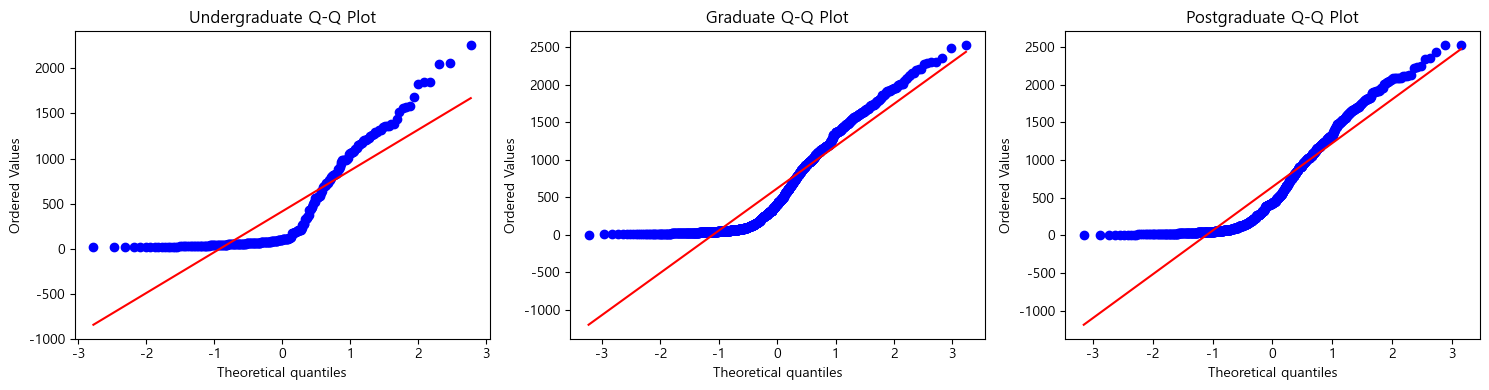

In [36]:
# TODO 4-1(b): Q-Q Plot (1×3 서브플롯)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, name in zip(axes, edu_groups):
    data = df[df["Education_Group"] == name]["Total_Spending"]
    stats.probplot(data, plot=ax)
    ax.set_title(f'{name} Q-Q Plot')

plt.tight_layout()
plt.show()

### 문제 4-2. ANOVA + 사후검정

문제 4-1의 정규성/등분산 검정 결과에 따라 적절한 검정을 수행합니다.

- 등분산 만족 → One-way ANOVA + **Tukey HSD** + Cohen's d
- 등분산 위반 → Welch's ANOVA + **Games-Howell** (`pg.pairwise_gameshowell()`) + Hedges' g
- 참고로 비모수 검정(Kruskal-Wallis)도 병행하여 결과의 일관성을 확인하세요.
- 효과 크기: η² + ω² (기준: 0.01 작은, 0.06 중간, 0.14 큰)
- 쌍별 효과 크기: Cohen's d / Hedges' g (기준: 0.2 미만 매우 작은, 0.2~0.5 작은, 0.5~0.8 중간, 0.8 이상 큰)

In [37]:
group_data = {g: df[df['Education_Group'] == g]['Total_Spending'].values for g in edu_groups}

# TODO 4-2(a): use_welch에 따라 ANOVA / Welch's ANOVA 수행 (Kruskal-Wallis도 병행)
# welchs 
welch = pg.welch_anova(dv= 'Total_Spending', between='Education_Group', data=df)
p= welch["p-unc"][0]
print(f"welch 아노바 검정: {p}로 귀무가설을 기각함, 그룹간 평균차이가 존재 ")

# (Kruskal-Wallis도 병행)
stat, p_k = stats.kruskal(Undergraduate, Graduate , Postgraduate)
print(f"Kruskal-Wallis 아노바 검정: {p_k}로 귀무가설을 기각함, 그룹간 평균차이가 존재 ")

# TODO 4-2(b): η² + ω² 계산 — ω² = (SS_between - (k-1)*MS_within) / (SS_total + MS_within)

groups = [g['Total_Spending'].values for _, g in df.groupby('Education_Group')]
k = len(groups)
N = len(df)

# SS 계산
grand_mean = df['Total_Spending'].mean()
ss_between = sum(len(g) * (g.mean() - grand_mean)**2 for g in groups)
ss_within = sum(((g - g.mean())**2).sum() for g in groups)
ss_total = ss_between + ss_within

ms_within = ss_within / (N - k)

# η²
eta_sq = ss_between / ss_total

# ω²
omega_sq = (ss_between - (k-1) * ms_within) / (ss_total + ms_within)

print(f"η² = {eta_sq:.4f}")
print(f"ω² = {omega_sq:.4f}, 중간 정도의 효과")

welch 아노바 검정: 4.09869586602897e-09로 귀무가설을 기각함, 그룹간 평균차이가 존재 
Kruskal-Wallis 아노바 검정: 1.1207736037427136e-08로 귀무가설을 기각함, 그룹간 평균차이가 존재 
η² = 0.0137
ω² = 0.0128, 중간 정도의 효과


In [38]:
# TODO 4-2(c): 사후검정 수행 + 해석 + 쌍별 효과크기
# 등분산 만족 → Tukey HSD + Cohen's d
# 등분산 위반 → Games-Howell (pg.pairwise_gameshowell) + Hedges' g
np2 =welch["np2"][0]
np2
gh = pg.pairwise_gameshowell(dv= 'Total_Spending', between='Education_Group', data=df)

print(f"\n welch 아노바 검정: 전체 효과 크기 {np2:.3f}")
print(f" welch 아노바 검정: 쌍별 효과 크기")
hedges= gh.loc[:,["A",	"B"	,"mean(A)",	"mean(B)",	"diff",	"hedges"] ]
display(hedges)

# dunn 검정 
import scikit_posthocs as sp
dunn = sp.posthoc_dunn(df, val_col='Total_Spending', group_col='Education_Group', p_adjust='bonferroni')

print(f"\nKruskal-Wallis 아노바 검정: dunn 검정, 중앙값차이 ")
display(dunn)
print(f"dunn 해석: Graduate VS Undergraduate, Postgraduate VS Undergraduate  유의미한 차이 발견 ")



 welch 아노바 검정: 전체 효과 크기 0.014
 welch 아노바 검정: 쌍별 효과 크기


,A,B,mean(A),mean(B),diff,hedges
0,Graduate,Postgraduate,620.394316,644.791813,-24.397497,-0.040121
1,Graduate,Undergraduate,620.394316,412.254902,208.139414,0.355688
2,Postgraduate,Undergraduate,644.791813,412.254902,232.536911,0.389636



Kruskal-Wallis 아노바 검정: dunn 검정, 중앙값차이 


,Graduate,Postgraduate,Undergraduate
Graduate,1.000000e+00,9.397459e-01,1.608179e-07
Postgraduate,9.397459e-01,1.000000e+00,9.226341e-09
Undergraduate,1.608179e-07,9.226341e-09,1.000000e+00


dunn 해석: Graduate VS Undergraduate, Postgraduate VS Undergraduate  유의미한 차이 발견 


In [39]:
print()
from itertools import combinations
group_data = {g: df[df['Education_Group'] == g]['Total_Spending'].values for g in edu_groups}
for (group_name1, group_data1), (group_name2, group_data2) in combinations(group_data.items(), 2): #조합 3C2 = 3개중에 2개를 뽑음
    # eftype='cohen': 일반 Cohen's d (편향 있음, 대표본에서 문제 없음)
    # eftype='hedges': Hedges' g (편향 조정, 소표본에서 권장)
    d = pg.compute_effsize(group_data1, group_data2, eftype='cohen')
    size_d = '매우 작은' if abs(d) < 0.2 else '작은' if abs(d) < 0.5 else '중간' if abs(d) < 0.8 else '큰'
    print(f"  {group_name1} vs {group_name2}: d = {d:.3f} ({size_d} 효과)")


  Undergraduate vs Graduate: d = -0.356 (작은 효과)
  Undergraduate vs Postgraduate: d = -0.390 (작은 효과)
  Graduate vs Postgraduate: d = -0.040 (매우 작은 효과)


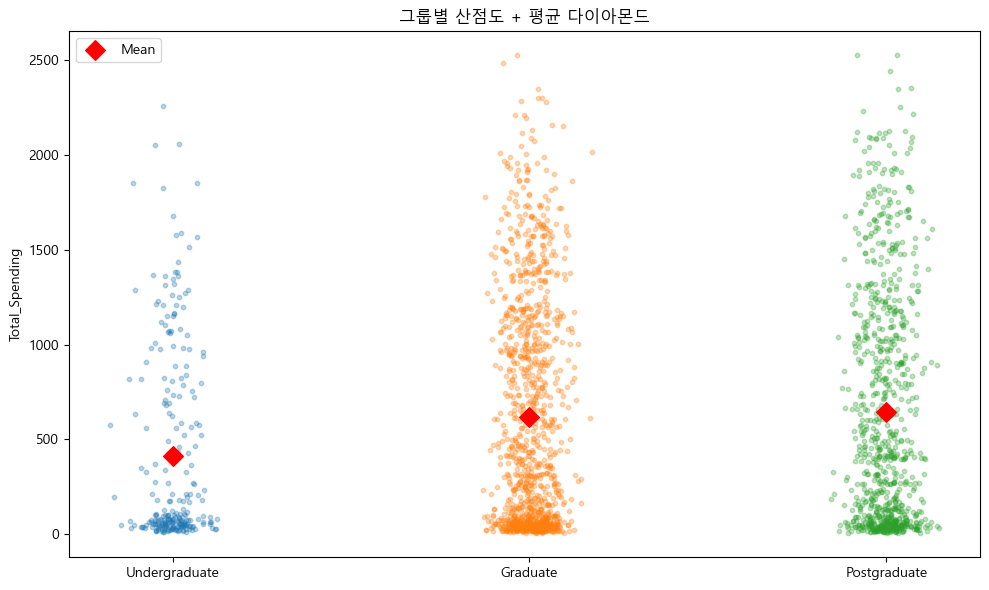

In [40]:
# TODO 4-2(d): 시각화 — 그룹별 개별 데이터 산점도 + 평균 다이아몬드

fig, ax = plt.subplots(figsize=(10, 6))

for i, name in enumerate(edu_groups):
    data = df[df['Education_Group'] == name]['Total_Spending']
    # 개별 데이터 산점도 (jitter 추가)
    x = np.random.normal(i, 0.05, size=len(data))
    ax.scatter(x, data, alpha=0.3, s=10)
    # 평균 다이아몬드
    ax.scatter(i, data.mean(), marker='D', color='red', s=100, zorder=5, label='Mean' if i == 0 else '')

ax.set_xticks(range(len(edu_groups)))
ax.set_xticklabels(edu_groups)
ax.set_ylabel('Total_Spending')
ax.set_title('그룹별 산점도 + 평균 다이아몬드')
ax.legend()
plt.tight_layout()
plt.show()

### 문제 4-3. 카이제곱 독립성 검정

**가설**: 결혼 상태(Marital_Group)와 캠페인 반응(Campaign_Response)은 독립인가?

- H₀: Marital_Group과 Campaign_Response는 독립이다.
- H₁: 두 변수는 독립이 아니다.

- 효과크기: φ (phi) = √(χ² / n) (기준: 0.1 작은, 0.3 중간, 0.5 큰)
- 오즈비(Odds Ratio): OR = (a×d) / (b×c), 95% CI = exp(ln(OR) ± 1.96 × SE)

> ⚠️ Cochran 규칙: 기대빈도 < 5인 셀이 전체의 20% 초과 시 Fisher 정확검정 필요

In [106]:
crosstab_no_margin = pd.crosstab(df['Marital_Group'], df['Campaign_Response'])

# TODO 4-3(a): 카이제곱 검정 수행 + Cochran 규칙 확인
chi2, p, dof, expected= stats.chi2_contingency(crosstab_no_margin)
display(expected)
# Cochran 규칙 확인 만족 모든 기대 빈도 5 이상
print(f"유의수준 5% 하 P-Value:{p:.3f}로 귀무가설 기각, 결혼 상태와 캠페인 반응여부는 독립적이지 않음")

# TODO 4-3(b): φ (phi) 계산
N= crosstab_no_margin.values.sum() 
phi = np.sqrt(chi2 / N)
print(f"\n φ (phi):{phi}로 0.1 보다 작아 무시할만한 효과크기가 나왔다.")


# TODO 4-3(c): 오즈비(Odds Ratio) + 95% CI 계산
a,b,c,d = crosstab_no_margin.values[0][0], crosstab_no_margin.values[0][1],crosstab_no_margin.values[1][0],crosstab_no_margin.values[1][1]
or_r = (a*d)/(c*b) 
print(f"\n 오즈비(Odds Ratio) :{or_r:.2f}로, 싱글그룹이 캠패인 반응을 안할 확률이 결혼그룹보다 0.74배 낮다. ")
print(f"즉, 싱글그룹이 결혼그룹보다 캠패인 반응을 할 확률이 1.35배 더 높다.")

# 로그 OR의 표준오차
se_log_or = np.sqrt(1/a + 1/b + 1/c + 1/d)

# 95% CI
z = 1.96
ci_lower = np.exp(np.log(or_r) - z * se_log_or)
ci_upper = np.exp(np.log(or_r) + z * se_log_or)
print(f"\n 95% 신뢰구간: 하한{ci_lower:.2f}, 상한 {ci_upper:.2f}로, 1을 포함하지 않으니 유의미한 연관이 존재")


array([[ 578.10017889,  215.89982111],
       [1049.89982111,  392.10017889]])

유의수준 5% 하 P-Value:0.002로 귀무가설 기각, 결혼 상태와 캠페인 반응여부는 독립적이지 않음

 φ (phi):0.06427230766297097로 0.1 보다 작아 무시할만한 효과크기가 나왔다.

 오즈비(Odds Ratio) :0.74로, 싱글그룹이 캠패인 반응을 안할 확률이 결혼그룹보다 0.74배 낮다. 
즉, 싱글그룹이 결혼그룹보다 캠패인 반응을 할 확률이 1.35배 더 높다.

 95% 신뢰구간: 하한0.61, 상한 0.90로, 1을 포함하지 않으니 유의미한 연관이 존재


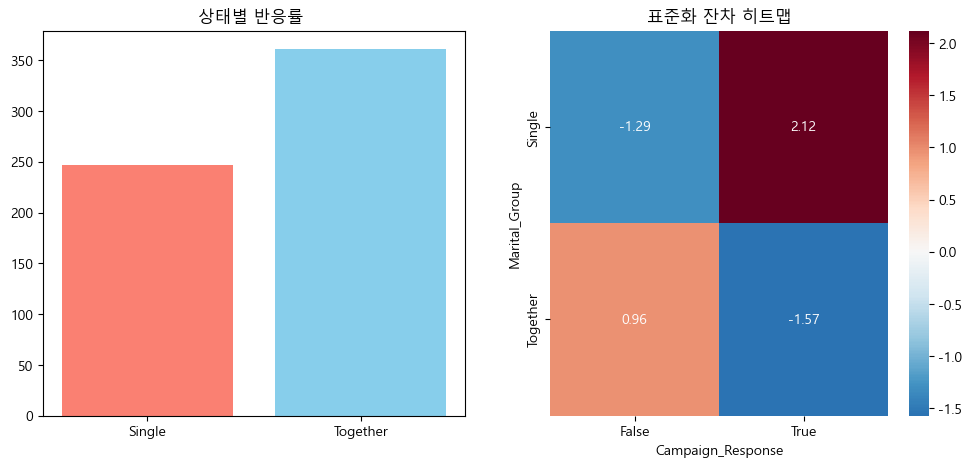

In [123]:
# TODO 4-3(d): (1) 결혼 상태별 반응률 막대그래프 (2) 표준화 잔차 히트맵
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1 상태별 반응률 
colors = ["salmon", "skyblue"]
respon1= df.groupby("Marital_Group")["Campaign_Response"].sum()
axes[0].bar(respon1.index, respon1.values, color=colors)
axes[0].set_title("상태별 반응률 ")

#(2) 표준화 잔차 히트맵
std_resid= (crosstab_no_margin- expected)/ np.sqrt(expected)
sns.heatmap(std_resid,  annot=True, fmt='.2f', cmap='RdBu_r', center=0,ax=axes[1])
axes[1].set_title("표준화 잔차 히트맵")

plt.show()

### 문제 4-4. 적합도 검정

3개 구매 채널(Web, Catalog, Store)의 총 구매 비율이 균등하게 분포하는지 검정합니다.

- H₀: 세 채널의 구매 비율이 동일하다 (1/3 : 1/3 : 1/3)
- H₁: 세 채널의 구매 비율이 동일하지 않다

Cohen's w = √(Σ(p_obs - p_exp)² / p_exp)

In [148]:
channel_totals = df[purchase_cols].sum()
channel_names = ['Web', 'Catalog', 'Store']
observed = channel_totals.values

# TODO 4-4(a): 기대빈도(균등) 계산 + 적합도 검정
n= observed.sum()
expc= np.array([n/3, n/3, n/3])

chi2, p = stats.chisquare(observed, expc)
print(f"유의수준 5% 하 P-Value:{p:.4f}로 귀무가설 기각, 세 채널의 구매 비율이 동일하지 않음 ")

# TODO 4-4(b): Cohen's w 계산
Cohen = np.sqrt(chi2/n)
print(f"\n Cohen's w:{Cohen:.2f}로 중간정도의 효과 크기를 보인다.")


유의수준 5% 하 P-Value:0.0000로 귀무가설 기각, 세 채널의 구매 비율이 동일하지 않음 

 Cohen's w:0.31로 중간정도의 효과 크기를 보인다.


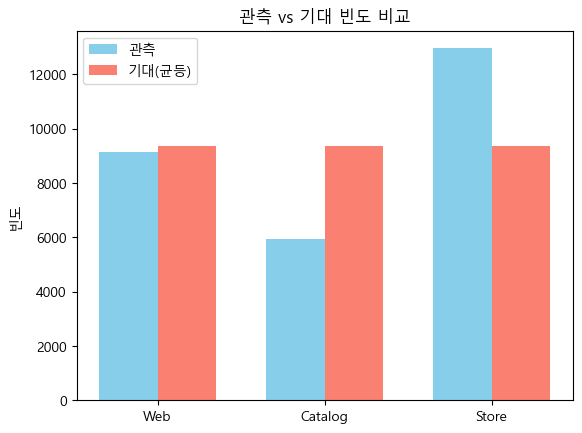


 매장구매 비율이 가장높다


In [147]:
# TODO 4-4(c): 관측 vs 기대(균등) 비교 막대그래프
labels = channel_names
x = np.arange(len(labels))
width = 0.35

plt.bar(x - width/2, observed, width, label='관측', color='skyblue')
plt.bar(x + width/2, expc, width, label='기대(균등)', color='salmon')
plt.xticks(x, labels)
plt.ylabel('빈도')
plt.title('관측 vs 기대 빈도 비교')
plt.legend()
plt.show()
print(f"\n 매장구매 비율이 가장높다")


---
## Part 5: 상관분석 / 비율 비교 — "변수 간 관계를 파악하고, 캠페인 효과를 검증할 수 있는가?"

변수 간 상관관계를 분석하고, A/B 테스트로 캠페인 효과를 검증합니다.

### 문제 5-1. 상관분석

6개 변수의 Pearson/Spearman 상관계수를 계산하고 히트맵으로 시각화하세요.
주요 변수 쌍에 대해 유의성 검정도 수행합니다.

In [177]:
corr_vars = ['Income', 'Age', 'Total_Spending', 'Total_Purchases',
             'NumWebVisitsMonth', 'Recency']

# TODO 5-1(a): Pearson/Spearman 상관행렬 계산
# Pearson
df_rel= df.loc[: , corr_vars]

Pearson_result = pg.pairwise_corr(df_rel, method='pearson')
Pearson= Pearson_result.loc[Pearson_result["p-unc"]<=0.05]
display(Pearson)

# Spearman
spearman_result = pg.pairwise_corr(df_rel, method='spearman')
spearman= spearman_result.loc[spearman_result["p-unc"]<=0.05]
display(spearman)

# TODO 5-1(b): 주요 상관계수 쌍의 유의성 검정 (stats.pearsonr)
r,p_1 = stats.pearsonr(df_rel["Income"], df_rel["Total_Spending"])
print(f" \n income VS total_spending 상관계수: {r:.2f} P-Value:{p_1:.3f} ")

r_2,p_2 = stats.pearsonr(df_rel["Income"], df_rel["Total_Purchases"])
print(f" \n income VS Total_Purchases 상관계수: {r_2:.2f} P-Value:{p_2:.3f} ")

r_3,p_3 = stats.pearsonr(df_rel["Total_Spending"], df_rel["Total_Purchases"])
print(f" \n Total_Spending VS Total_Purchases 상관계수: {r_3:.2f} P-Value:{p_3:.3f} ")

r_4,p_4 = stats.pearsonr(df_rel["NumWebVisitsMonth"], df_rel["Total_Spending"])
print(f" \n NumWebVisitsMonth VS Total_Spending 상관계수: {r_4:.2f} P-Value:{p_4:.3f} ")



,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power
0,Income,Age,pearson,two-sided,2236,0.198835,"[0.16, 0.24]",2.269594e-21,9.421e+17,1.000000
1,Income,Total_Spending,pearson,two-sided,2236,0.789375,"[0.77, 0.8]",0.000000e+00,inf,1.000000
2,Income,Total_Purchases,pearson,two-sided,2236,0.738647,"[0.72, 0.76]",0.000000e+00,inf,1.000000
3,Income,NumWebVisitsMonth,pearson,two-sided,2236,-0.646382,"[-0.67, -0.62]",9.867293e-265,4.084e+260,1.000000
5,Age,Total_Spending,pearson,two-sided,2236,0.113618,"[0.07, 0.15]",7.163790e-08,5.256e+04,0.999702
6,Age,Total_Purchases,pearson,two-sided,2236,0.173004,"[0.13, 0.21]",1.746297e-16,1.416e+13,1.000000
7,Age,NumWebVisitsMonth,pearson,two-sided,2236,-0.117498,"[-0.16, -0.08]",2.514897e-08,1.449e+05,0.999852
9,Total_Spending,Total_Purchases,pearson,two-sided,2236,0.821091,"[0.81, 0.83]",0.000000e+00,inf,1.000000
10,Total_Spending,NumWebVisitsMonth,pearson,two-sided,2236,-0.499909,"[-0.53, -0.47]",1.072711e-141,6.252e+137,1.000000
12,Total_Purchases,NumWebVisitsMonth,pearson,two-sided,2236,-0.426734,"[-0.46, -0.39]",1.205638e-99,7.1e+95,1.000000


,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,Income,Age,spearman,two-sided,2236,0.216515,"[0.18, 0.26]",3.948422e-25,1.000000
1,Income,Total_Spending,spearman,two-sided,2236,0.849491,"[0.84, 0.86]",0.000000e+00,1.000000
2,Income,Total_Purchases,spearman,two-sided,2236,0.776796,"[0.76, 0.79]",0.000000e+00,1.000000
3,Income,NumWebVisitsMonth,spearman,two-sided,2236,-0.640295,"[-0.66, -0.62]",3.024429e-258,1.000000
5,Age,Total_Spending,spearman,two-sided,2236,0.157677,"[0.12, 0.2]",6.441612e-14,1.000000
6,Age,Total_Purchases,spearman,two-sided,2236,0.179340,"[0.14, 0.22]",1.285733e-17,1.000000
7,Age,NumWebVisitsMonth,spearman,two-sided,2236,-0.129426,"[-0.17, -0.09]",8.121773e-10,0.999986
9,Total_Spending,Total_Purchases,spearman,two-sided,2236,0.908447,"[0.9, 0.92]",0.000000e+00,1.000000
10,Total_Spending,NumWebVisitsMonth,spearman,two-sided,2236,-0.476821,"[-0.51, -0.44]",2.631604e-127,1.000000
12,Total_Purchases,NumWebVisitsMonth,spearman,two-sided,2236,-0.420867,"[-0.45, -0.39]",1.065701e-96,1.000000


 
 income VS total_spending 상관계수: 0.79 P-Value:0.000 
 
 income VS Total_Purchases 상관계수: 0.74 P-Value:0.000 
 
 Total_Spending VS Total_Purchases 상관계수: 0.82 P-Value:0.000 
 
 NumWebVisitsMonth VS Total_Spending 상관계수: -0.50 P-Value:0.000 


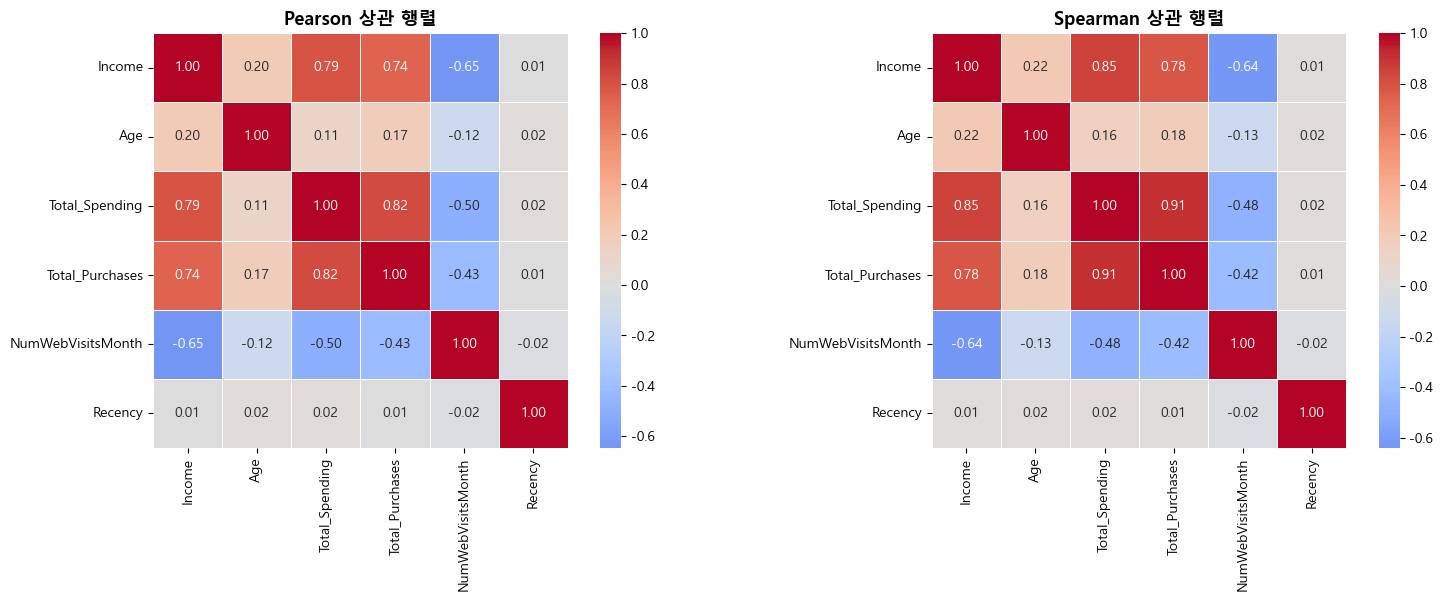

In [171]:
# TODO 5-1(c): 상관행렬 히트맵 (Pearson + Spearman, 1×2 서브플롯)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pearson
sns.heatmap(df_rel.corr(method="pearson"), annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, ax=axes[0])
axes[0].set_title('Pearson 상관 행렬', fontsize=13, fontweight='bold')

# Spearman
sns.heatmap(df_rel.corr(method='spearman'), annot=True, fmt='.2f', 
            cmap='coolwarm', center=0, square=True, linewidths=0.5, ax=axes[1])
axes[1].set_title('Spearman 상관 행렬', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

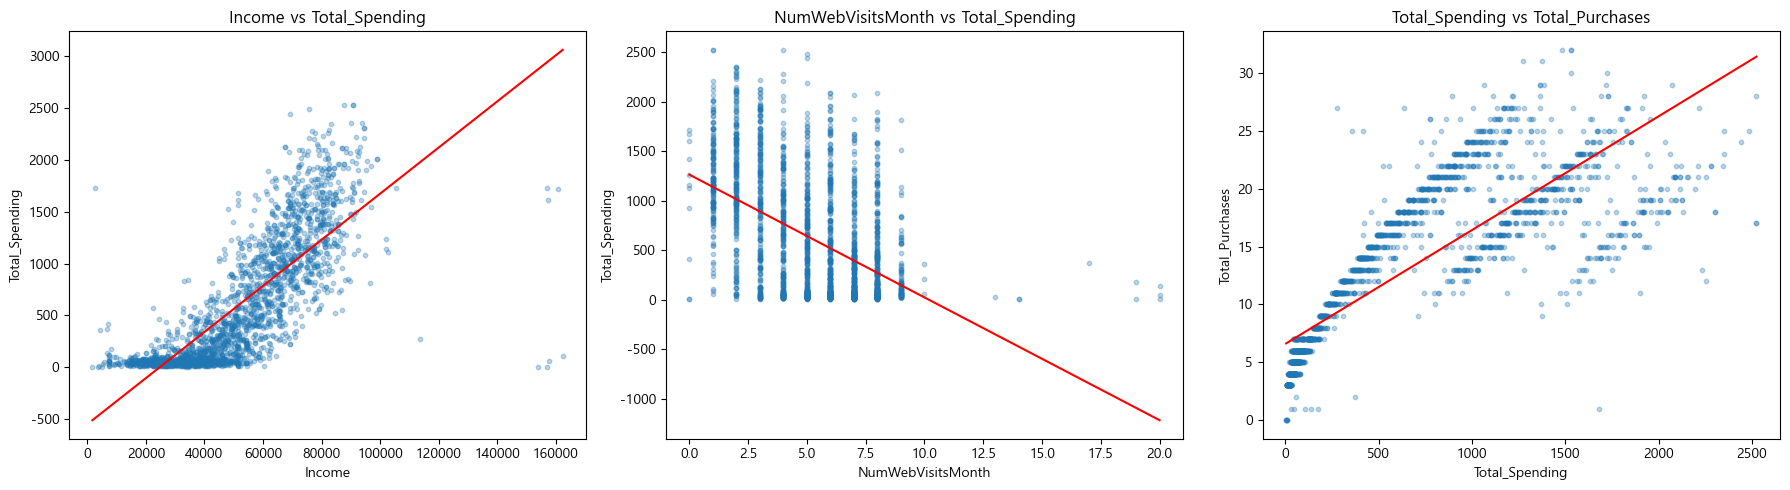

In [181]:
# TODO 5-1(d): 주요 변수 쌍 산점도 + 추세선 (1×3 서브플롯)
# 대상: (Income, Total_Spending), (NumWebVisitsMonth, Total_Spending), (Total_Spending, Total_Purchases)
# np.polyfit()으로 1차 추세선을 그리세요
pairs = [('Income', 'Total_Spending'), 
         ('NumWebVisitsMonth', 'Total_Spending'), 
         ('Total_Spending', 'Total_Purchases')]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (x_col, y_col) in zip(axes, pairs):
    x = df[x_col]
    y = df[y_col]
    
    ax.scatter(x, y, alpha=0.3, s=10)
    
    # 1차 추세선
    m, b = np.polyfit(x, y, 1)
    ax.plot(x.sort_values(), m * x.sort_values() + b, color='red')
    
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(f'{x_col} vs {y_col}')

plt.tight_layout()
plt.show()

### 문제 5-2. 두 그룹 비율 비교 (관찰 연구)

이전 캠페인 반응 경험 유무에 따라 마지막 캠페인(Response) 수락률에 차이가 있는지 검증합니다.

- **Group A**: AcceptedCmp1~5 합계 = 0 (이전 캠페인 무반응)
- **Group B**: AcceptedCmp1~5 합계 ≥ 1 (이전 캠페인 반응 경험)
- **지표**: Response (마지막 캠페인 수락률)
- **검정 방법**: z-비율검정 + Cohen's h + Wilson 신뢰구간

> **주의**: 이 분석은 A/B 테스트가 **아닙니다**. \
> A/B 테스트는 연구자가 참가자를 **무작위로 배정** (Random Assignment)하는 실험입니다. \
> 여기서는 고객이 과거 행동에 의해 스스로 그룹에 배정되었으므로 **관찰 연구**이며, \
> 인과관계를 주장할 수 없습니다.

In [205]:
cmp_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
df['Prior_Response'] = df[cmp_cols].sum(axis=1)

group_a = df[df['Prior_Response'] == 0]
group_b = df[df['Prior_Response'] >= 1]

n_a, n_b = len(group_a), len(group_b)
conv_a = group_a['Response'].sum()
conv_b = group_b['Response'].sum()
rate_a = conv_a / n_a
rate_b = conv_b / n_b
print(f"이전 캠페인 무반응 그룹: {rate_a:.2f}, 이전 캠페인 반응 경험 그룹:{rate_b:.2f}" )
print(n_a,n_b ) 
print("소표본 아님") 

# TODO 5-2(a): z-비율검정
count = [conv_a, conv_b ]
nob = [n_a, n_b]
z,p= proportions_ztest(count,nob, alternative= "two-sided" )
print(f" \n 유의수준 5% 하 P-Value:{p:.3f}로 귀무가설 기각, 이전 캠패인 반응여부에 따라 마지막 캠패인 수락율에 차이가 존재함 ")

# TODO 5-2(b): Cohen's h 효과 크기

h = proportion_effectsize(rate_a, rate_b)
print(f" \n Cohen's h 효과 크기:{h:.3f}, 두그룹의 효과크기는 매우 높다. ")

# TODO 5-2(c): Wilson 신뢰구간
from statsmodels.stats.proportion import confint_proportions_2indep
ci_low, ci_upp = confint_proportions_2indep(conv_a, n_a, conv_b, n_b, method='wald')

print(f" \n Wilson 신뢰구간: 하한{ci_low:.3f}, 상한{ci_upp:.3f} ")


이전 캠페인 무반응 그룹: 0.08, 이전 캠페인 반응 경험 그룹:0.41
1774 462
소표본 아님
 
 유의수준 5% 하 P-Value:0.000로 귀무가설 기각, 이전 캠패인 반응여부에 따라 마지막 캠패인 수락율에 차이가 존재함 
 
 Cohen's h 효과 크기:-0.802, 두그룹의 효과크기는 매우 높다. 
 
 Wilson 신뢰구간: 하한-0.371, 상한-0.278 


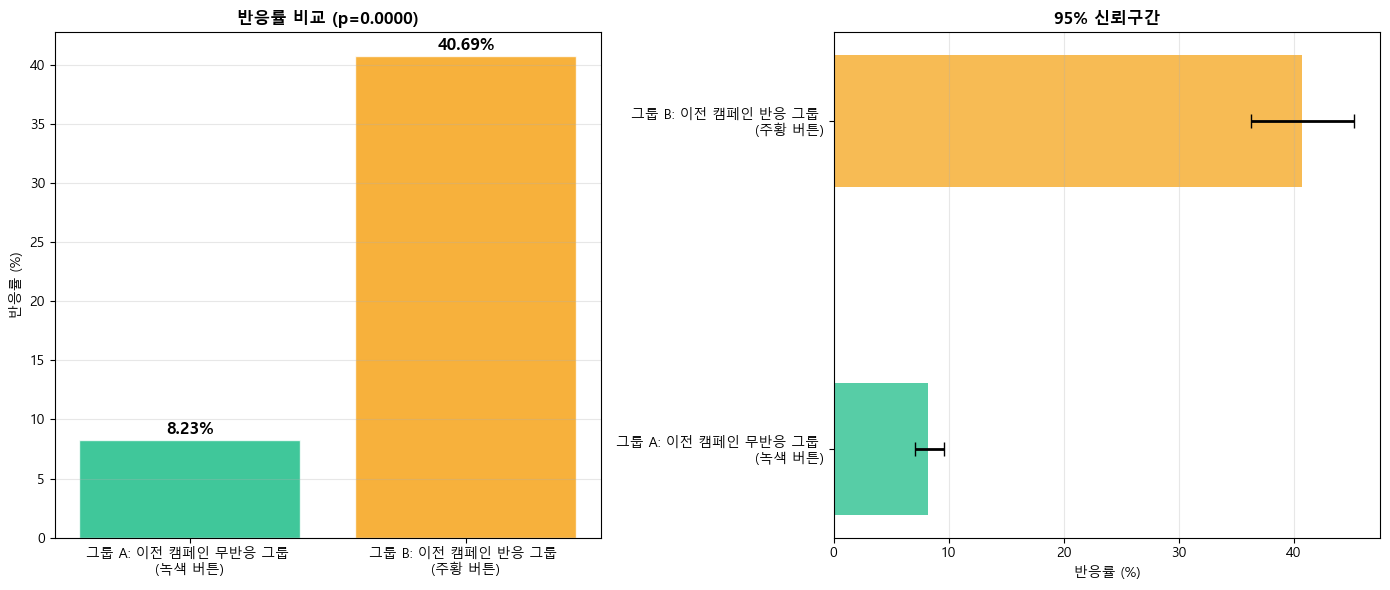

In [212]:
# TODO 5-2(d): 수락률 비교 시각화 (CI 오차막대 포함)
# ── 전환율 비교 시각화 ──
def plot_ab_test(control_count, treatment_count, n_control, n_treatment, 
                 control_label='대조군', treatment_label='실험군',
                 colors=['#10B981', '#F59E0B']):
    
    # 전환율
    rate_c = control_count / n_control
    rate_t = treatment_count / n_treatment
    
    # z검정
    from statsmodels.stats.proportion import proportions_ztest, proportion_confint
    stat, p = proportions_ztest([control_count, treatment_count], [n_control, n_treatment])
    
    # Wilson CI
    ci_c = proportion_confint(control_count, n_control, alpha=0.05, method='wilson')
    ci_t = proportion_confint(treatment_count, n_treatment, alpha=0.05, method='wilson')
    
    rates = [rate_c * 100, rate_t * 100]
    labels = [control_label, treatment_label]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # (1) 막대 그래프
    bars = axes[0].bar(labels, rates, color=colors, alpha=0.8, edgecolor='white')
    for bar, rate in zip(bars, rates):
        axes[0].text(bar.get_x() + bar.get_width()/2., rate + 0.2,
                     f'{rate:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('반응률 (%)')
    axes[0].set_title(f'반응률 비교 (p={p:.4f})', fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    
    # (2) 신뢰구간
    y_pos = [0, 1]
    cis = [ci_c, ci_t]
    xerr = [[r - ci[0]*100 for r, ci in zip(rates, cis)],
            [ci[1]*100 - r for r, ci in zip(rates, cis)]]
    
    axes[1].barh(y_pos, rates, color=colors, alpha=0.7, height=0.4)
    axes[1].errorbar(rates, y_pos, xerr=xerr, fmt='none', color='black', capsize=5, linewidth=2)
    axes[1].set_yticks(y_pos)
    axes[1].set_yticklabels(labels)
    axes[1].set_xlabel('반응률 (%)')
    axes[1].set_title('95% 신뢰구간', fontweight='bold')
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_ab_test(
    control_count=conv_a.sum(),
    treatment_count=conv_b.sum(),
    n_control=n_a,
    n_treatment=n_b,
    control_label='그룹 A: 이전 캠페인 무반응 그룹 \n(녹색 버튼)',
    treatment_label='그룹 B: 이전 캠페인 반응 그룹 \n(주황 버튼)'
)

> ⚠️ **이 분석이 A/B 테스트가 아닌 이유**
>
> A/B 테스트의 본질은 '무작위 배정(Random Assignment)'입니다.
>
> - **A/B 테스트**: 연구자가 참가자를 무작위로 배정 → 인과관계 추론 가능
> - **이 분석**: 고객의 과거 행동으로 그룹이 결정 → 관찰 연구, 인과관계 주장 불가
>
> → 인과관계를 검증하려면 무작위 배정 실험(RCT)을 설계해야 합니다. (문제 5-3)

### 문제 5-3. 진정한 A/B 테스트 설계

새로운 캠페인이 기존 수락률 대비 **2%p** 개선을 가져올 수 있는지 탐지하기 위한
최소 표본 크기를 산정하세요. (α=0.05, Power=0.80)

In [223]:
baseline_rate = df['Response'].mean()
target_rate = baseline_rate + 0.02
mde = 0.02 

# TODO 5-3(a): Cohen's h 계산
h_2 = proportion_effectsize(target_rate,baseline_rate)
print(f" \n Cohen's h 효과 크기:{h_2:.3f}, 두그룹의 효과크기는 매우 낮다. 이효과를 통계적으로 감지하고자 한다면 매우 큰 표본수가 필요하다. ")

# TODO 5-3(b): NormalIndPower()로 필요 표본 크기 산정 (α=0.05, Power=0.80, 단측)
power_analysis = NormalIndPower()
needn = power_analysis.solve_power(
    effect_size= abs(h_2),
    alpha=0.05,          
    power=0.80,      
    alternative='larger' 
)
print(f" \n 필요 표본 크기 :{needn:.3f} ")


 
 Cohen's h 효과 크기:0.055, 두그룹의 효과크기는 매우 낮다. 이효과를 통계적으로 감지하고자 한다면 매우 큰 표본수가 필요하다. 
 
 필요 표본 크기 :4137.793 


---
## Challenge: 종합 분석 보고서

지금까지의 분석을 종합하여 FreshCart 마케팅팀에 제출할 보고서를 작성합니다.

### Challenge 1. 고객 그룹별 특성 분석

`Income_Group` × `Has_Children` 6개 조합에 대해 다음을 포함하는 종합 분석표를 작성하세요:

- 고객 수, 평균 소득, 평균/중앙값 소비, 평균 구매 수, 캠페인 반응률, 웹 방문 수
- 그룹 비교 시각화 (1×3 서브플롯: 평균 소비, 반응률, 고객 수)

고객수      평균소득     평균소비   중앙값소비  평균구매수  캠페인반응률  웹방문수
Income_Group Has_Children                                                     
Low          False         115  24380.24   145.01    73.0   6.40    0.13   797
             True          631  29172.88    86.69    54.0   5.67    0.17  4355
Mid          False          80  52209.63   721.24   653.0  15.36    0.35   374
             True          665  51466.09   426.25   368.0  12.34    0.20  3903
High         False         442  78697.96  1424.02  1383.0  19.22    0.55  1046
             True          303  71841.61  1033.12  1005.0  19.18    0.28  1418

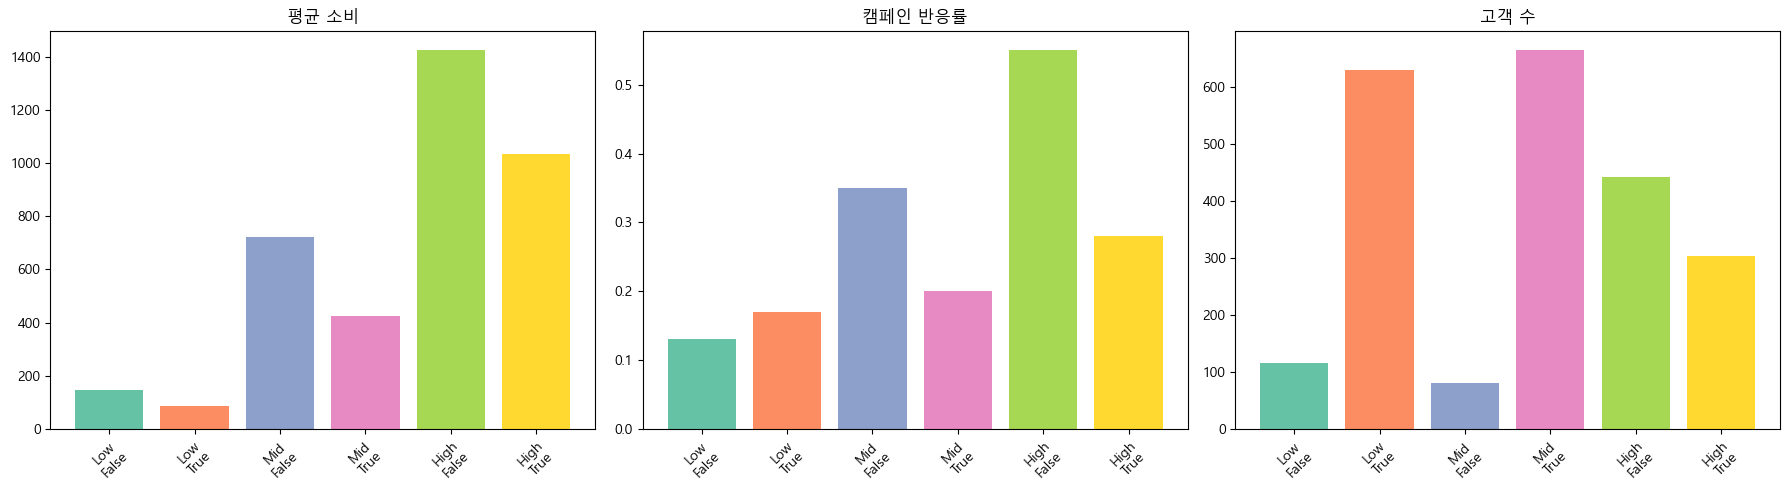

In [228]:
# TODO C-1: 고객 그룹별 특성 분석 종합표 + 시각화

# 종합 분석표
summary = df.groupby(['Income_Group', 'Has_Children']).agg(
    고객수=('Income', 'count'),
    평균소득=('Income', 'mean'),
    평균소비=('Total_Spending', 'mean'),
    중앙값소비=('Total_Spending', 'median'),
    평균구매수=('Total_Purchases', 'mean'),
    캠페인반응률=('Campaign_Response', 'mean'),
    웹방문수=('NumWebVisitsMonth', 'sum')
).round(2)

display(summary)

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 언피벗용
plot_df = summary.reset_index()
plot_df['label'] = plot_df['Income_Group'].astype(str) + '\n' + plot_df['Has_Children'].astype(str)

# (1) 평균 소비
axes[0].bar(plot_df['label'], plot_df['평균소비'], color=plt.cm.Set2(range(len(plot_df))))
axes[0].set_title('평균 소비')
axes[0].tick_params(axis='x', rotation=45)

# (2) 반응률
axes[1].bar(plot_df['label'], plot_df['캠페인반응률'], color=plt.cm.Set2(range(len(plot_df))))
axes[1].set_title('캠페인 반응률')
axes[1].tick_params(axis='x', rotation=45)

# (3) 고객 수
axes[2].bar(plot_df['label'], plot_df['고객수'], color=plt.cm.Set2(range(len(plot_df))))
axes[2].set_title('고객 수')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Challenge 2. 비즈니스 제안서

분석 결과를 종합하여 다음을 포함하는 제안서를 작성하세요:

1. **타겟 고객**: 어떤 그룹를 우선 집중 공략해야 하는가? (근거 포함)
2. **채널 전략**: 소득 그룹별 최적 마케팅 채널은?
3. **기대 효과**: 집중 공략 기반 예상 개선 효과
4. **한계점**: 분석의 한계와 추가 필요 데이터

# TODO C-2: 비즈니스 제안서 작성
1.타켓고객 
- 소득이 높고, 아이를 가지지 않은 그룹에서 평균 소비량이 많고 캠패인 반응률도 높다. 우선공략의 필요성 있음
- 자녀 여부에 따른 그룹에서도 Cohen's d: 1.25로 매우 큰 효과 두 평균의 차이가 표준편차의 크기보다 크다.
- 싱글 그룹의 캠패인 반응률도 결혼 그룹과 비교하여 통계적으로 유의미한 차이가 존재하기에 우선 공략 대상이된다.
- 자녀가 없는 고객층 위주로 타켓고객을 설정한다면 유의미한 결과를 얻을 수도 있다. 
2. 채널 전략
- 채널 분포는 균등하지 않고 실 매장 채널 이용 빈도가 매우 높다. 
- 그룹간 Cohen's w:0.31로 중간정도의 효과 크기를 보인다. 
- 매장 점포 증진과 웹사이트 이용률 증진이 우선 목표가 되며, 추가 비용에 따른 비즈니스적 선택이 필요하다. 
3. 기대 효과
- 추가로 모델 제작에 들어간다면, 
- 자녀 보유 여부 또는 생활 형태에 따른 캠패인 반응율, 평균 소비액 등을 설명하고 예측 할 수 있을 것이다.   
4. 추가 인사이트 
- 캠패인 반응율이 낮지만 소비량이 높은 그룹을 찾을 수 있다면 낮은 마케팅 비용 대비 높은 수익을 올릴 수 있는 그룹을 찾을 수도 있을 것이다. 

---
## 수고하셨습니다!

설날 연휴 따뜻하고 복 가득한 시간 보내요! 💛